# Machine Learning Approaches for News Analysis

By: Michael Mizzi

The scope of this workbook is to apply KNN on the features extracted from the two data sets provided, police press releases and news articles.

Dataset used : `data_post_eda.csv`


## K-Nearest Neighbours [KNN] in our context:
- Is Regression or Classification adequate?  --> we will focus on Classification
- What is the the optimal K paramter?
- Do we consider process time required? Do we need to optimize searching?
- Is KNN a suitable ML model to adopt in our scenario?

## Predictor Questions we target to answer using this classifier
- Predict Low/ High severity accidents based on selected features (weather, street type, month, accident time, driver age
- Predict Fatality in incidents based on vehicle type, street type, time of the day and holiday category

## 1. Introducton to Technique

Based on theoretical descriptions by Prof. Konstantinos Makantasis
delivered during ***Applied Machine Learning*** module (2025-2026)

### 1.1 Theory


The k-nearest neighbours (KNN) method is a non-parametric algorithm that classifies data points based on the majority class among their k closest neighbours in feature space. It is used both ofr regression and classification modelling.

When applying KNN, user setting of two key parameters:
-  'k' representing the number of neighbours used to detmerine categorization of output label
-  The metric used to determine distance of the input to each training point; Euclidean distance, manhattan distance, Cosine distance.

For KNN model training input features sohuld be one-hot encoded (if categorical) or Label encodied if featrures are ordinal.

The split of the dataset for training, testing and validation is a key aspect to consider, especially with a limited dataset of ~210 observations. In this notebook we will explore the resutls based on two main methodologies:

1.    Splitting the dataset as 70/20/10 for trianing/testing/validation
2.    Splitting the dataset in 5-fold stratified testing method.

Generating KNN visualization with k=3...


/tmp/ipython-input-300324975.py:42: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=cmp_bold.colors, s=100, edgecolor='k')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


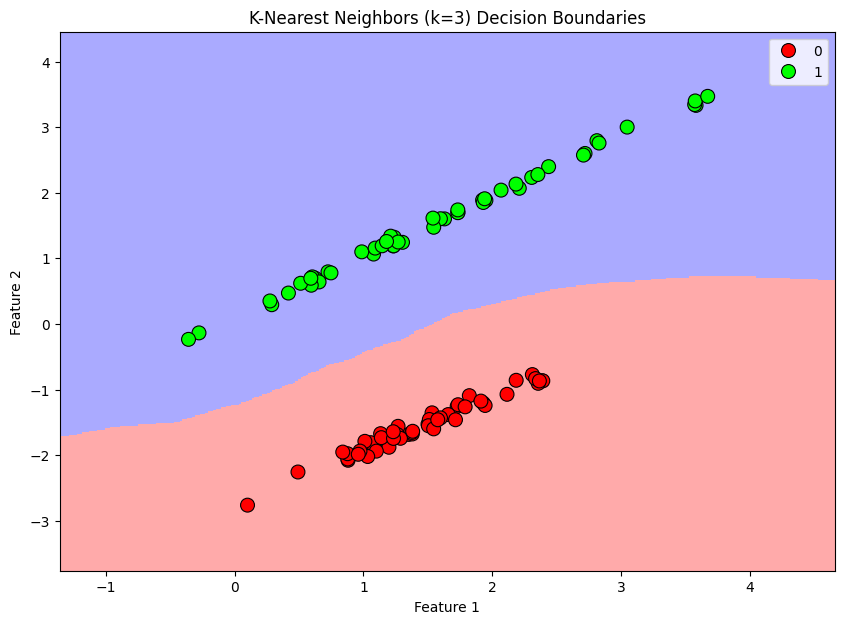

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

print("Generating KNN visualization with k=3...")

# Create a synthetic dataset for binary classification
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, random_state=42, class_sep=1.5)

# Set the value of k for KNN
k_value = 3

# Create color maps for the plot
cmp_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmp_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Create an instance of KNeighborsClassifier with k=3
knn_classifier = KNeighborsClassifier(n_neighbors=k_value)

# Fit the model to the data
knn_classifier.fit(X, y)

# Determine the mesh grid for plotting decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict class for each point in the meshgrid
Z = knn_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 7))
plt.pcolormesh(xx, yy, Z, cmap=cmp_light, shading='auto')

# Plot the training points
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=cmp_bold.colors, s=100, edgecolor='k')

plt.title(f'K-Nearest Neighbors (k={k_value}) Decision Boundaries')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


### 1.2 Suitability

In this context we focus on KNN as a `Classifier` rather than to perform `Regression`.

In section 2 we will assess the data robustness, balance and also re-assess feature reducion based on high correlation

## 2. Preprocessing

### 2.1 Importing Libraries and loading dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import KBinsDiscretizer
from datetime import datetime
import warnings

from sklearn.decomposition import PCA


warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [3]:
df = pd.read_csv('data_post_eda.csv')
print("Dataset loaded successfully.")
print(f"Shape of the dataset: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset loaded successfully.
Shape of the dataset: 211 rows, 58 columns


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          211 non-null    object 
 1   date_published              211 non-null    object 
 2   accident_datetime           211 non-null    object 
 3   accident_severity           211 non-null    object 
 4   total_injured               211 non-null    int64  
 5   city                        211 non-null    object 
 6   street                      211 non-null    object 
 7   accident_time_category      211 non-null    object 
 8   driver_under_18             211 non-null    bool   
 9   driver_18_to_24             211 non-null    bool   
 10  driver_25_to_49             211 non-null    bool   
 11  driver_50_to_64             211 non-null    bool   
 12  driver_65_plus              211 non-null    bool   
 13  driver_age_unknown          211 non

In [5]:
# Keep only the specified columns
columns_to_keep = [
    #'id', 'date_published', 'accident_datetime',
    'accident_severity', 'total_injured',
    #'city', 'street',
    'accident_time_category',
    #'driver_under_18', 'driver_18_to_24', 'driver_25_to_49','driver_50_to_64', 'driver_65_plus', 'driver_age_unknown',
    'num_drivers_under_18', 'num_drivers_18_to_24', 'num_drivers_25_to_49',
    'num_drivers_50_to_64', 'num_drivers_65_plus', 'num_drivers_age_unknown',
    #'driver_male', 'driver_female', 'driver_gender_unknown',
    'num_drivers_male', 'num_drivers_female', 'num_drivers_gender_unknown', 'num_drivers_total',
    #'vehicle_unknown', 'vehicle_pedestrian', 'vehicle_bicycle', 'vehicle_motorbike',
    #'vehicle_car', 'vehicle_van', 'vehicle_bus',
    'num_vehicle_unknown', 'num_vehicle_pedestrian', 'num_vehicle_bicycle',
    'num_vehicle_motorbike', 'num_vehicle_car', 'num_vehicle_van', 'num_vehicle_bus',
    'is_weekend', 'is_public_holiday_mt', 'is_school_holiday_mt', #'is_school_day_mt',
    'street_type', 'region', 'temperature_mean', #'temperature_min', ,'temperature_max'
    #'precipitation_sum', 'windspeed_max',
    'is_raining', 'traffic_level', #'accident_year',
    'accident_month', 'accident_day_of_week', # 'accident_hour'
   ]

df = df[columns_to_keep]

print(f"✓ Dataset filtered to {len(columns_to_keep)} columns")
print(f"New shape: {df.shape[0]} rows, {df.shape[1]} columns")
df.info()

✓ Dataset filtered to 30 columns
New shape: 211 rows, 30 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   accident_severity           211 non-null    object 
 1   total_injured               211 non-null    int64  
 2   accident_time_category      211 non-null    object 
 3   num_drivers_under_18        211 non-null    int64  
 4   num_drivers_18_to_24        211 non-null    int64  
 5   num_drivers_25_to_49        211 non-null    int64  
 6   num_drivers_50_to_64        211 non-null    int64  
 7   num_drivers_65_plus         211 non-null    int64  
 8   num_drivers_age_unknown     211 non-null    int64  
 9   num_drivers_male            211 non-null    int64  
 10  num_drivers_female          211 non-null    int64  
 11  num_drivers_gender_unknown  211 non-null    int64  
 12  num_drivers_total          

In [6]:
df.head()

,accident_severity,total_injured,accident_time_category,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,num_drivers_male,...,is_weekend,is_public_holiday_mt,is_school_holiday_mt,street_type,region,temperature_mean,is_raining,traffic_level,accident_month,accident_day_of_week
0,not injured,0,night,0,0,0,0,0,1,0,...,False,True,False,primary,Central,16.0,False,LOW,3,1
1,not injured,0,night,0,0,1,0,0,1,2,...,False,False,False,residential,Northern,23.5,True,LOW,9,0
2,not injured,0,afternoon,0,0,0,0,1,1,1,...,False,False,False,trunk,Northern,17.6,True,MODERATE,12,2
3,grievious,1,morning,0,0,1,0,0,0,0,...,False,False,False,residential,Northern,14.9,False,LOW,12,2
4,fatal,1,afternoon,0,0,0,1,0,0,1,...,False,False,False,trunk,Northern,15.4,False,LOW,12,2


Check for outliers - Old incidents and observatons with empty or 'unknown' data
   
1.   check for feature data that is empty or contains 'unknown' / 'none'
2.   check for empty data within hte observations


In [7]:
# checking for empty data
empty_cols = df.columns[df.isnull().any()].tolist()

if empty_cols:
    print("Columns with empty data (NaN values):")
    for col in empty_cols:
        print(f"- {col}: {df[col].isnull().sum()} empty values")
else:
    print("No columns found with empty data (NaN values).")

No columns found with empty data (NaN values).


In [8]:
# checking for any data entries with 'unknown' or 'none'
columns_with_unknown = []
columns_with_none = []
for col in df.columns:
    if df[col].astype(str).str.contains('unknown', case=False, na=False).any():
        columns_with_unknown.append(col)
    if df[col].astype(str).str.contains('none', case=False, na=False).any():
        columns_with_none.append(col)

if columns_with_unknown:
    print("Columns containing 'unknown' values:")
    for col_name in columns_with_unknown:
        print(f"- {col_name}")
else:
    print("No columns found containing 'unknown' values.")

if columns_with_none:
    print("\nColumns containing 'none' values:")
    for col_name in columns_with_none:
        print(f"- {col_name}")
else:
    print("No columns found containing 'none' values.")

No columns found containing 'unknown' values.
No columns found containing 'none' values.


### 2.2 Encoding data
Step 1: Add column to extract only accident fatality

Step 2: Classifiying severity as 'high' or 'low'

Step 3: one-hot encoding of accident_time_category, street type, region

Step 4: Label encoding for traffic intensity

Step 5: Convert all boolean data points to '0' / '1'

In [9]:
df['fatality'] = df['accident_severity'].apply(lambda x: 1 if 'fatal' in x.lower() else 0)

print("✓ New target column 'fatality' created successfully.")
print("Distribution of 'fatality':")
print(df['fatality'].value_counts())
print(f"New shape of DataFrame: {df.shape[0]} rows, {df.shape[1]} columns")

✓ New target column 'fatality' created successfully.
Distribution of 'fatality':
fatality
0    183
1     28
Name: count, dtype: int64
New shape of DataFrame: 211 rows, 31 columns


In [10]:
# Define the ordinal mapping for accident_severity
# Assuming a logical order from least severe to most severe
severity_order = {
    'not injured': 0,
    'slight': 0,
    'grievious': 1,
    'serious': 1,
    'fatal': 1
}

# Apply the ordinal mapping to the 'accident_severity' column
df['accident_severity'] = df['accident_severity'].map(severity_order)

print("✓ 'accident_severity' column ordinally encoded and original column replaced.")
print(f"New shape of DataFrame: {df.shape[0]} rows, {df.shape[1]} columns")
print("First 5 rows of the new encoded column:")
print(df['accident_severity'].head())

✓ 'accident_severity' column ordinally encoded and original column replaced.
New shape of DataFrame: 211 rows, 31 columns
First 5 rows of the new encoded column:
0    0
1    0
2    0
3    1
4    1
Name: accident_severity, dtype: int64


In [11]:
# Define columns to be one-hot encoded
columns_to_onehot_encode = ['street_type', 'region', 'accident_time_category']

# Perform one-hot encoding using pandas get_dummies
df = pd.get_dummies(df, columns=columns_to_onehot_encode, prefix=columns_to_onehot_encode)

print("✓ One-hot encoding applied to 'street_type' and 'region' columns.")
print(f"New shape of DataFrame after encoding: {df.shape[0]} rows, {df.shape[1]} columns")
print("First 5 rows of the new encoded 'street_type' columns:")
print(df[[col for col in df.columns if 'street_type_' in col]].head())
print("First 5 rows of the new encoded 'region' columns:")
print(df[[col for col in df.columns if 'region_' in col]].head())
print("First 5 rows of the new encoded 'accident_time_category' columns:")
print(df[[col for col in df.columns if 'accident_time_category_' in col]].head())

✓ One-hot encoding applied to 'street_type' and 'region' columns.
New shape of DataFrame after encoding: 211 rows, 45 columns
First 5 rows of the new encoded 'street_type' columns:
   street_type_other  street_type_primary  street_type_residential  \
0              False                 True                    False   
1              False                False                     True   
2              False                False                    False   
3              False                False                     True   
4              False                False                    False   

   street_type_secondary  street_type_tertiary  street_type_trunk  
0                  False                 False              False  
1                  False                 False              False  
2                  False                 False               True  
3                  False                 False              False  
4                  False                 False            

In [12]:
# Define the ordinal mapping for traffic_level
traffic_level_order = {
    'LOW': 0,
    'MODERATE': 1,
    'HEAVY': 2
}

# Apply the ordinal mapping to the 'traffic_level' column
df['traffic_level_encoded'] = df['traffic_level'].map(traffic_level_order)

# Drop the original 'traffic_level' column
df = df.drop(columns=['traffic_level'])

print("✓ 'traffic_level' column ordinally encoded and original column replaced.")
print(f"New shape of DataFrame: {df.shape[0]} rows, {df.shape[1]} columns")
print("First 5 rows of the new 'traffic_level_encoded' column:")
print(df['traffic_level_encoded'].head())

✓ 'traffic_level' column ordinally encoded and original column replaced.
New shape of DataFrame: 211 rows, 45 columns
First 5 rows of the new 'traffic_level_encoded' column:
0    0
1    0
2    1
3    0
4    0
Name: traffic_level_encoded, dtype: int64


In [13]:
# Identify boolean columns
bool_cols = df.select_dtypes(include=['bool']).columns

# Convert boolean columns to int (0 or 1)
df[bool_cols] = df[bool_cols].astype(int)

print(f"✓ Converted {len(bool_cols)} boolean columns to integers (0 or 1).")
print("First 5 rows of the updated DataFrame (boolean columns are now 0/1):")

df.head()

✓ Converted 21 boolean columns to integers (0 or 1).
First 5 rows of the updated DataFrame (boolean columns are now 0/1):


,accident_severity,total_injured,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,num_drivers_male,num_drivers_female,...,region_Northern,region_South Eastern,region_Southern Harbour,accident_time_category_afternoon,accident_time_category_early_morning,accident_time_category_evening,accident_time_category_late_evening,accident_time_category_morning,accident_time_category_night,traffic_level_encoded
0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,1,1,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 45 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   accident_severity                     211 non-null    int64  
 1   total_injured                         211 non-null    int64  
 2   num_drivers_under_18                  211 non-null    int64  
 3   num_drivers_18_to_24                  211 non-null    int64  
 4   num_drivers_25_to_49                  211 non-null    int64  
 5   num_drivers_50_to_64                  211 non-null    int64  
 6   num_drivers_65_plus                   211 non-null    int64  
 7   num_drivers_age_unknown               211 non-null    int64  
 8   num_drivers_male                      211 non-null    int64  
 9   num_drivers_female                    211 non-null    int64  
 10  num_drivers_gender_unknown            211 non-null    int64  
 11  num_drivers_total  

### 2.3  Exploratory section to visualize data during model setting

In [15]:
df.head()

,accident_severity,total_injured,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,num_drivers_male,num_drivers_female,...,region_Northern,region_South Eastern,region_Southern Harbour,accident_time_category_afternoon,accident_time_category_early_morning,accident_time_category_evening,accident_time_category_late_evening,accident_time_category_morning,accident_time_category_night,traffic_level_encoded
0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,1,1,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0


In [16]:
df.describe()

,accident_severity,total_injured,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,num_drivers_male,num_drivers_female,...,region_Northern,region_South Eastern,region_Southern Harbour,accident_time_category_afternoon,accident_time_category_early_morning,accident_time_category_evening,accident_time_category_late_evening,accident_time_category_morning,accident_time_category_night,traffic_level_encoded
count,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,...,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,0.886256,1.336493,0.037915,0.208531,0.739336,0.270142,0.208531,0.194313,1.099526,0.317536,...,0.274882,0.165877,0.218009,0.317536,0.118483,0.109005,0.061611,0.213270,0.180095,0.194313
std,0.318255,1.058096,0.191444,0.451583,0.758016,0.505220,0.462007,0.473252,0.720152,0.524291,...,0.447516,0.372855,0.413876,0.466625,0.323948,0.312386,0.241020,0.410591,0.385180,0.452681
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.500000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,9.000000,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,4.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


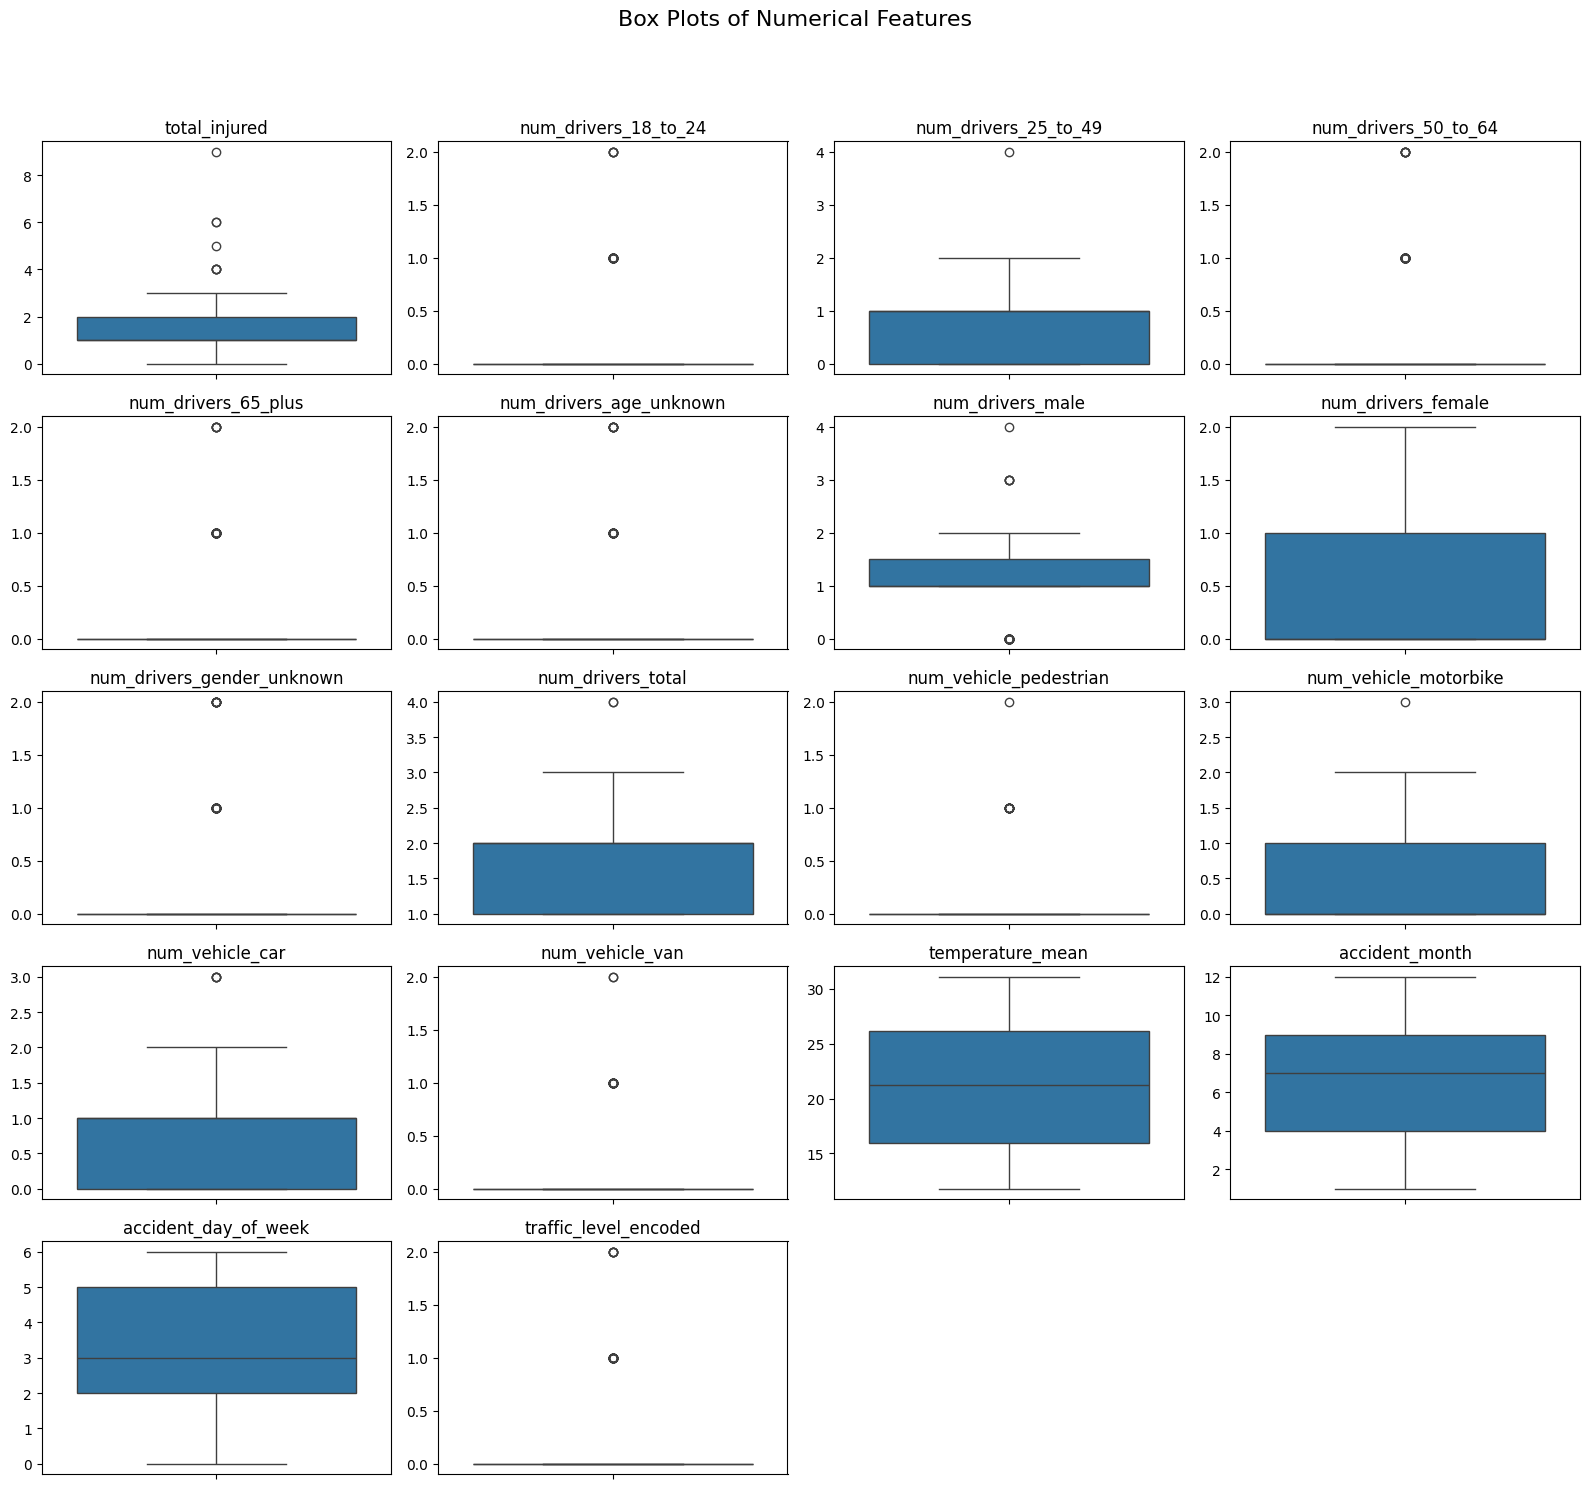

✓ Box plots for numerical columns generated successfully.


In [17]:
# Identify numerical columns suitable for box plots (i.e., not binary/one-hot encoded)
# Exclude columns that are clearly binary (0 or 1) as box plots are not very informative for them

# Get all numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

columns_for_boxplot = []
for col in numerical_cols:
    # Heuristic: if a column has more than 2 unique values, it's likely not a simple binary/one-hot indicator
    # Also, exclude the 'accident_severity' and 'fatality' columns as their box plots might not be very insightful given their current encoding
    if df[col].nunique() > 2 and col not in ['accident_severity', 'fatality']:
        columns_for_boxplot.append(col)

# Define the number of columns for the subplot grid
n_cols = 4
n_rows = (len(columns_for_boxplot) + n_cols - 1) // n_cols # Calculate rows needed

plt.figure(figsize=(n_cols * 4, n_rows * 3))
plt.suptitle('Box Plots of Numerical Features', y=1.02, fontsize=16)

for i, col in enumerate(columns_for_boxplot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.ylabel('') # Remove y-axis label to avoid clutter, as title is descriptive

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

print("✓ Box plots for numerical columns generated successfully.")

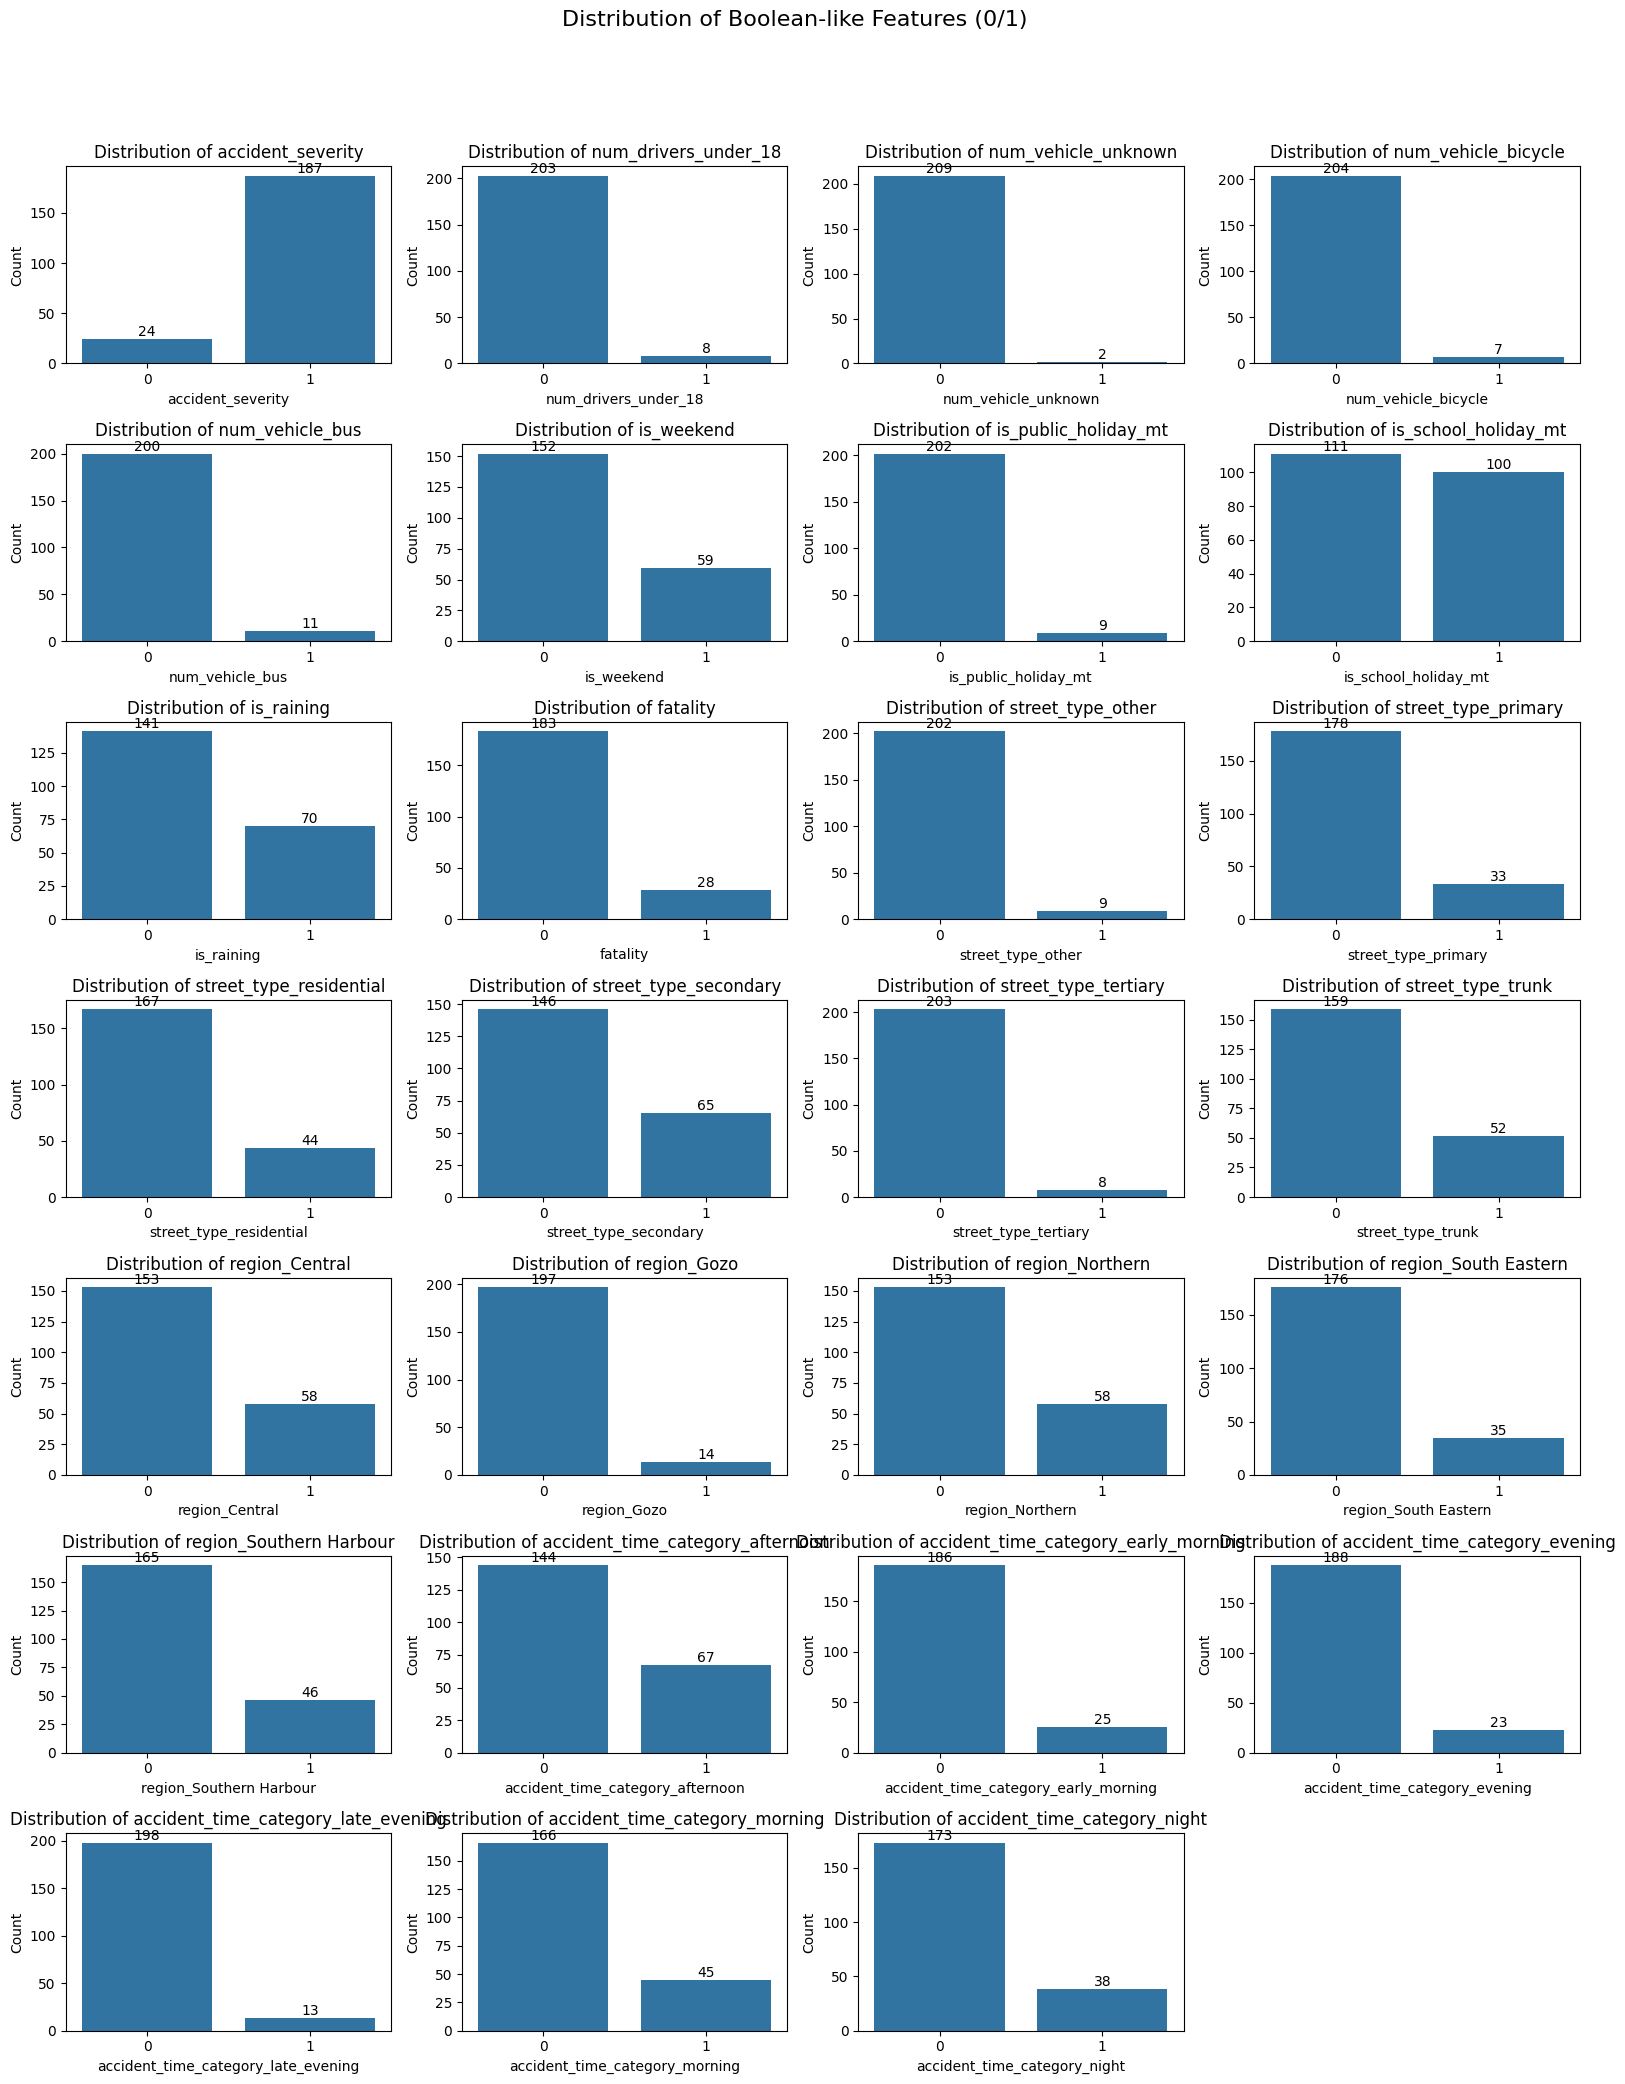

✓ Count plots for boolean-like columns generated successfully.


In [18]:
# Identify boolean-like columns (columns with exactly two unique values, 0 and 1)
bool_like_cols = []
for col in df.columns:
    if df[col].nunique() == 2 and set(df[col].unique()) == {0, 1}:
        bool_like_cols.append(col)

if not bool_like_cols:
    print("No boolean-like columns (0/1) found in the DataFrame to plot.")
else:
    n_cols = 4  # Number of columns for the subplot grid
    n_rows = (len(bool_like_cols) + n_cols - 1) // n_cols # Calculate rows needed

    plt.figure(figsize=(n_cols * 4, n_rows * 3))
    plt.suptitle('Distribution of Boolean-like Features (0/1)', y=1.02, fontsize=16)

    for i, col in enumerate(bool_like_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.countplot(x=df[col])
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        # Optional: Add value counts as text on bars
        for container in plt.gca().containers:
            plt.gca().bar_label(container)

    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.show()

    print("✓ Count plots for boolean-like columns generated successfully.")

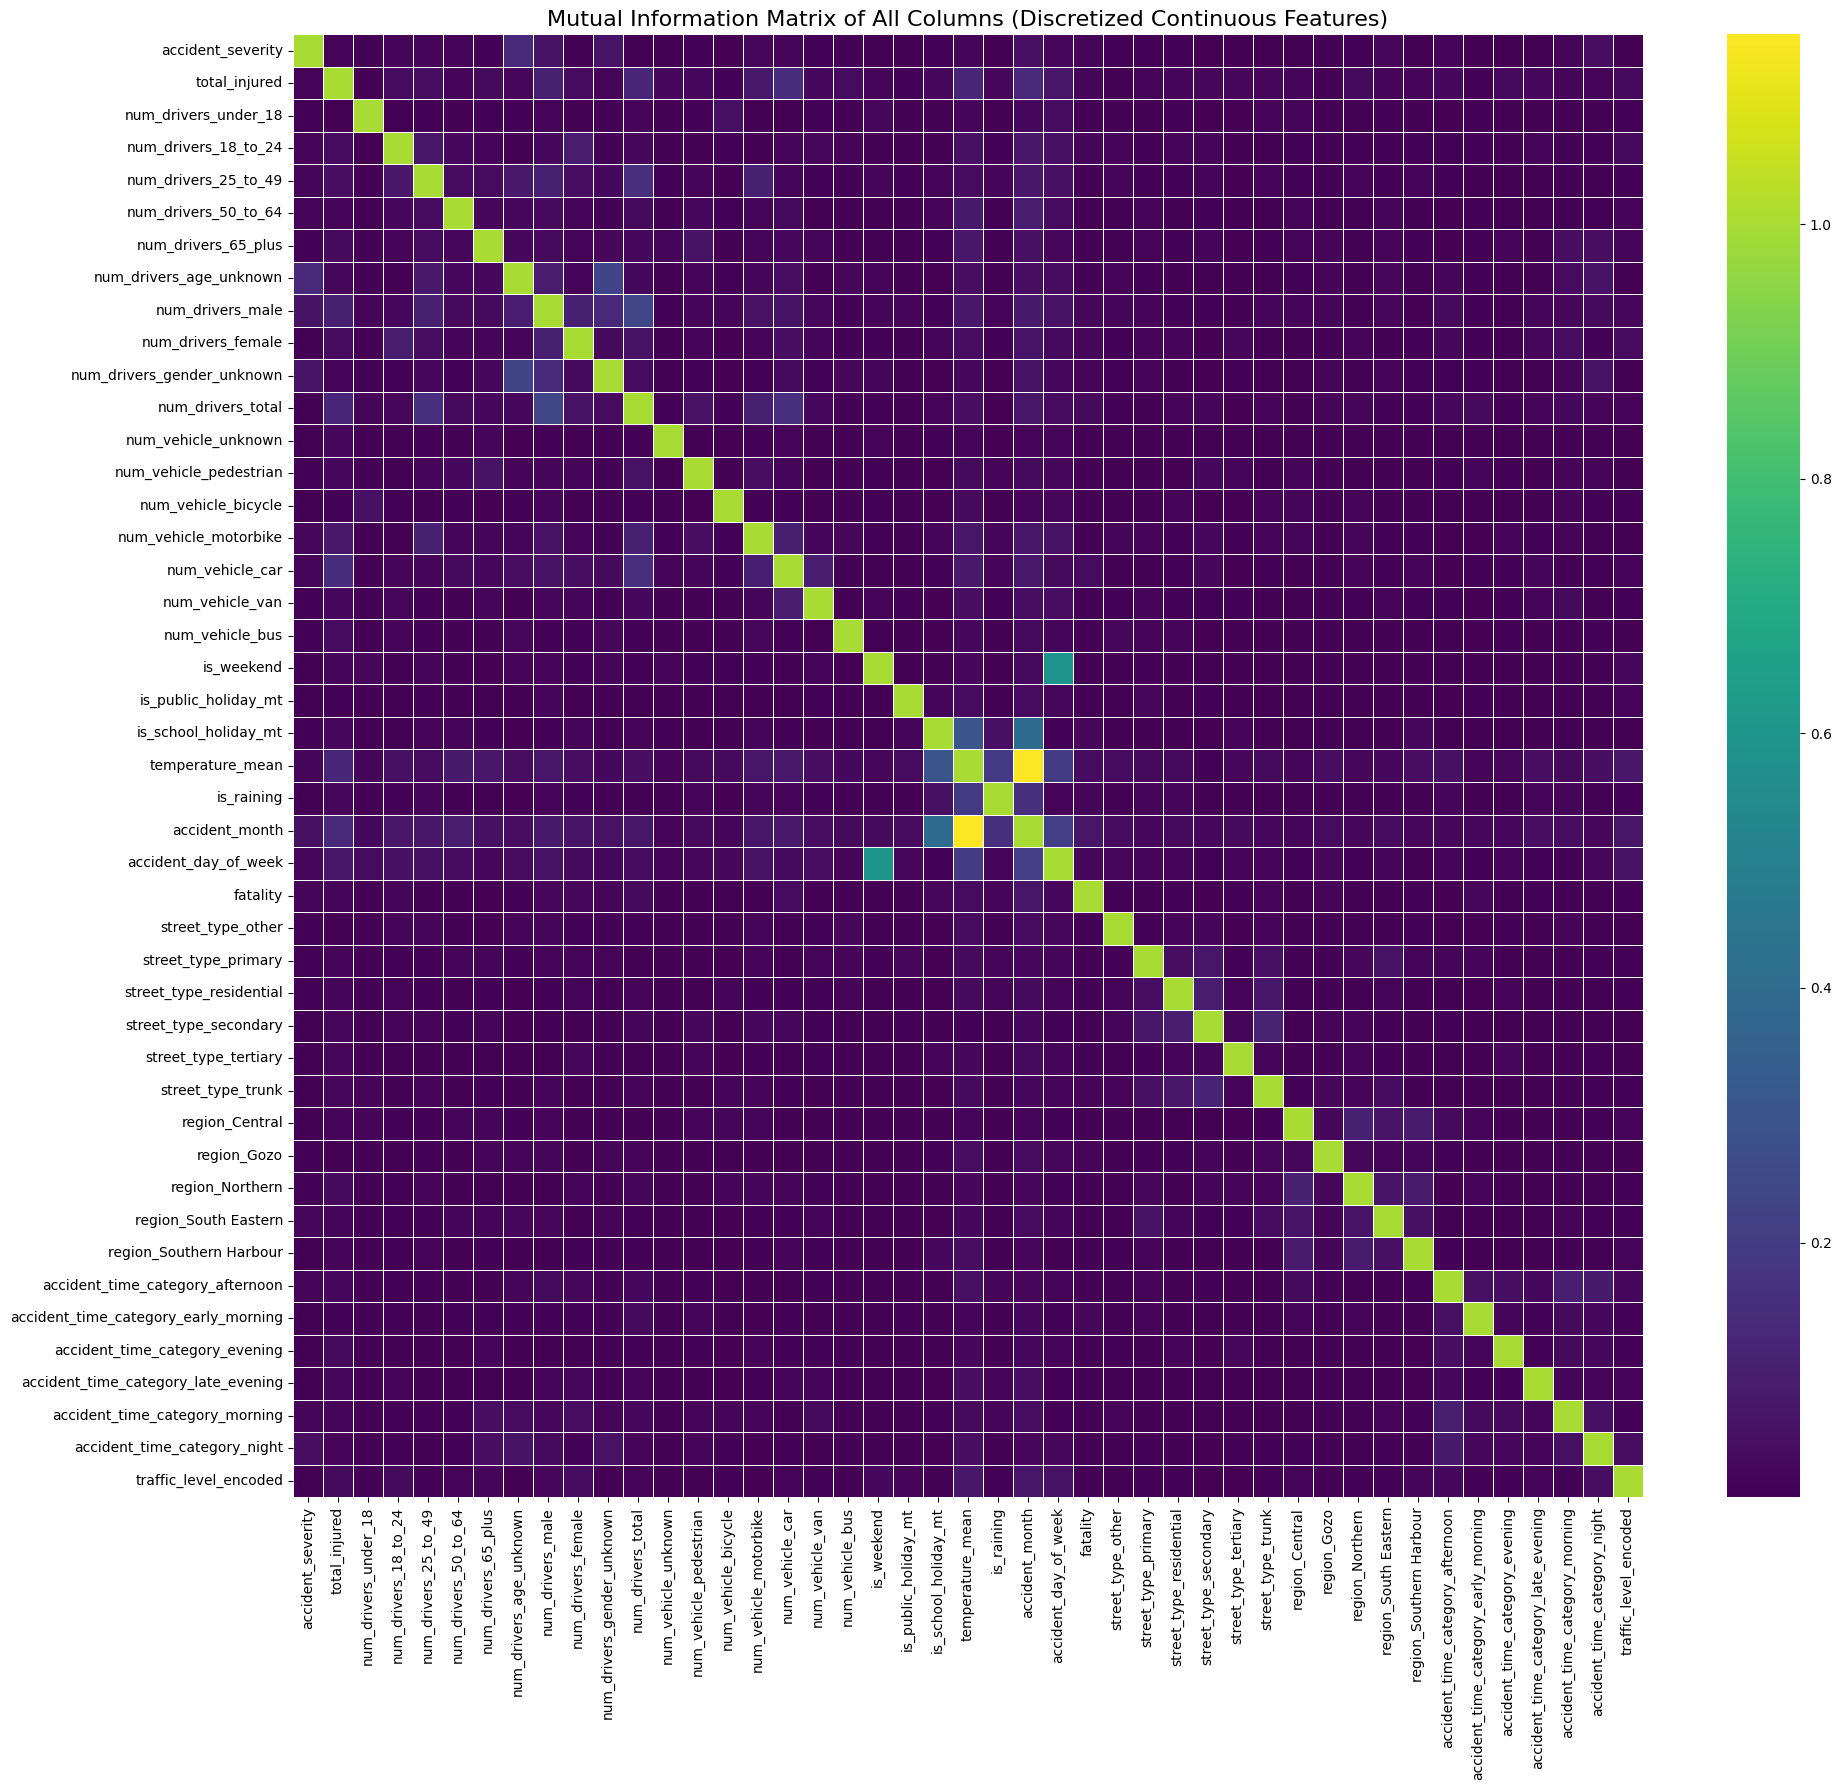

✓ Mutual Information matrix calculated and plotted successfully.


In [19]:
# Make a copy of the DataFrame to avoid modifying the original during discretization
df_mi = df.copy()

# Identify numerical columns that are not already binary (0/1)
numerical_cols_for_discretization = []
for col in df_mi.columns:
    if pd.api.types.is_numeric_dtype(df_mi[col]) and df_mi[col].nunique() > 2:
        numerical_cols_for_discretization.append(col)

# Apply KBinsDiscretizer to continuous numerical columns
# Using strategy='uniform' to have equally spaced bins
# n_bins can be adjusted. A value like 5 or 10 is often reasonable.
# Consider handling columns with very few unique values separately if they are treated as continuous.
for col in numerical_cols_for_discretization:
    # Ensure the number of bins doesn't exceed the number of unique values
    n_bins_for_col = min(10, df_mi[col].nunique())
    if n_bins_for_col > 1: # Only discretize if there's more than one unique value to bin
        discretizer = KBinsDiscretizer(n_bins=n_bins_for_col, encode='ordinal', strategy='uniform', subsample=None)
        df_mi[col] = discretizer.fit_transform(df_mi[[col]])
    else:
        # If only 1 unique value, it's effectively constant, no need to discretize or it becomes 0
        # Or if 2 unique values, it's already binary, no need to discretize further
        pass

# Calculate Mutual Information matrix
# This function expects discrete features. We'll treat all columns as discrete after preprocessing.
# We will calculate MI for each column against every other column.
mi_matrix = pd.DataFrame(index=df_mi.columns, columns=df_mi.columns)

for col1 in df_mi.columns:
    for col2 in df_mi.columns:
        if col1 == col2:
            mi_matrix.loc[col1, col2] = 1.0 # MI of a variable with itself is maximum (normalized to 1 for heatmap visualization)
        else:
            # Ensure the input to mutual_info_classif is 1D for y
            mi = mutual_info_classif(df_mi[[col1]], df_mi[col2], discrete_features=True)
            mi_matrix.loc[col1, col2] = mi[0]

mi_matrix = mi_matrix.astype(float)

# Plotting the heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(mi_matrix, annot=False, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Mutual Information Matrix of All Columns (Discretized Continuous Features)', fontsize=16)
plt.tight_layout()
plt.show()

print("✓ Mutual Information matrix calculated and plotted successfully.")

Based on the visual correlation from the MI plot we will remove the following features from the df:
- num_drivers_gender_unknown
- accident_month
- accident_day_of_week
Originally dropped but then reconsidered:
- num_drivers_male
- num_drivers_female

In [20]:
columns_to_drop = [
    'num_drivers_gender_unknown',
    'accident_month',
    'accident_day_of_week',
   # 'num_drivers_male',
   # 'num_drivers_female'
]

df = df.drop(columns=columns_to_drop)

print(f"✓ Dropped {len(columns_to_drop)} columns successfully.")
print(f"New shape: {df.shape[0]} rows, {df.shape[1]} columns")
df.info()

✓ Dropped 3 columns successfully.
New shape: 211 rows, 42 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 42 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   accident_severity                     211 non-null    int64  
 1   total_injured                         211 non-null    int64  
 2   num_drivers_under_18                  211 non-null    int64  
 3   num_drivers_18_to_24                  211 non-null    int64  
 4   num_drivers_25_to_49                  211 non-null    int64  
 5   num_drivers_50_to_64                  211 non-null    int64  
 6   num_drivers_65_plus                   211 non-null    int64  
 7   num_drivers_age_unknown               211 non-null    int64  
 8   num_drivers_male                      211 non-null    int64  
 9   num_drivers_female                    211 non-null    int64  
 10  num_drivers_total   

Summary of Dataset (40 columns):

Features:

- Temporal - Day  : 3x
- Temporal - Time / traffic :  7x
- Location - Area/ street info : 11x
- Vehicle type : 7x
- Environment :  2x
- Drivers' details:  7x

Labels: 3x
- Severity
- Fatality
- Number of injured people


###  2.4  Define datasets for Training, testing and vlaidation (split 70/20/10)

- Define and tag datasets
- split 70/20/10
- Normalize feature datasets
- ensure label datasets are integers

Features are grouped by context; temporal, location, vehicle, environment and driver details to improve the flexibility when training model with different fetures

STEP 1 --> Define model features / label & split X (features), y (Labels)



In [21]:
# Define the label columns
label_columns = ['accident_severity','fatality','total_injured']

#grouping features
day_features = ['is_weekend', 'is_public_holiday_mt', 'is_school_holiday_mt']
time_features = ['accident_time_category_early_morning', 'accident_time_category_morning', 'accident_time_category_afternoon',
                 'accident_time_category_evening','accident_time_category_late_evening', 'accident_time_category_night','traffic_level_encoded']
location_features = ['street_type_other','street_type_primary','street_type_residential','street_type_secondary','street_type_tertiary','street_type_trunk',
                     'region_Central','region_Gozo','region_Northern','region_South Eastern','region_Southern Harbour']
vehicle_features = ['num_vehicle_unknown','num_vehicle_pedestrian','num_vehicle_bicycle','num_vehicle_motorbike','num_vehicle_car',
                    'num_vehicle_van','num_vehicle_bus']
env_features = ['is_raining','traffic_level_encoded']
driver_features = ['num_drivers_under_18','num_drivers_18_to_24','num_drivers_25_to_49','num_drivers_50_to_64','num_drivers_65_plus',
                   'num_drivers_age_unknown','num_drivers_total']

#test = df[label_columns,day_features,time_features,location_features,vehicle_features,env_features,driver_features]

#test.info()


# Create the labels DataFrame (y)
y = df[label_columns]

# Create the features DataFrame (X) representing all features
X = df.drop(columns=label_columns)
Xday = df[day_features]
Xtime = df[time_features]
Xlocation = df[location_features]
Xvehicle = df[vehicle_features]
Xenv = df[env_features]
Xdriver = df[driver_features]
Xslim = df[['is_weekend', 'traffic_level_encoded', 'region_Central', 'region_Gozo', 'region_Northern', 'region_South Eastern', 'region_Southern Harbour',
           'num_vehicle_motorbike', 'num_vehicle_car', 'num_vehicle_van', 'num_vehicle_bus', 'is_raining', 'traffic_level_encoded', 'num_drivers_total']]
#the slim version of the feture set is a biased version based on my personal logic.
#It is set to hypotetically assess any significant change in accuracy of the model

print("Overview of dataframes prepared for model training")
print(f"Shape of X (features): {X.shape[0]} rows, {X.shape[1]} columns represents all injected features")
print(f"Shape of Xday (features): {X.shape[0]} rows, {Xday.shape[1]} columns represents features related to the day of the accident")
print(f"Shape of Xtime (features): {X.shape[0]} rows, {Xtime.shape[1]} columns represents features related to the accident's time/traffic")
print(f"Shape of Xlocation (features): {X.shape[0]} rows, {Xlocation.shape[1]} columns represents features related to the accident's location")
print(f"Shape of Xvehicle (features): {X.shape[0]} rows, {Xvehicle.shape[1]} columns represents features related to the vehicles involved")
print(f"Shape of Xenv (features): {X.shape[0]} rows, {Xenv.shape[1]} columns represents features related to the accident's weather condition")
print(f"Shape of Xdriver (features): {X.shape[0]} rows, {Xdriver.shape[1]} columns represents features related to the drivers involved in the accident")
print(f"Shape of Xslim (features): {X.shape[0]} rows, {Xslim.shape[1]} columns represents a biased reduced feature selection from aech category")
print(f"Shape of y (labels): {y.shape[0]} rows, {y.shape[1]} columns")


Overview of dataframes prepared for model training
Shape of X (features): 211 rows, 39 columns represents all injected features
Shape of Xday (features): 211 rows, 3 columns represents features related to the day of the accident
Shape of Xtime (features): 211 rows, 7 columns represents features related to the accident's time/traffic
Shape of Xlocation (features): 211 rows, 11 columns represents features related to the accident's location
Shape of Xvehicle (features): 211 rows, 7 columns represents features related to the vehicles involved
Shape of Xenv (features): 211 rows, 2 columns represents features related to the accident's weather condition
Shape of Xdriver (features): 211 rows, 7 columns represents features related to the drivers involved in the accident
Shape of Xslim (features): 211 rows, 14 columns represents a biased reduced feature selection from aech category
Shape of y (labels): 211 rows, 3 columns


STEP 2 --> split data set (70% train, 20% test and 10% validate)

In [22]:
# Split data into 70% training and 30% (test+validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=43)

# Split the 30% (test+validation) into 20% test and 10% validation
# This means splitting X_temp/y_temp (which is 30% of the original data) into 2/3 (test) and 1/3 (validation)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33333333, random_state=43)

# Apply the same splits to the other feature dataframes for consistency
Xday_train, Xday_temp = train_test_split(Xday, test_size=0.3, random_state=43)
Xday_test, Xday_val = train_test_split(Xday_temp, test_size=0.33333333, random_state=43)

Xtime_train, Xtime_temp = train_test_split(Xtime, test_size=0.3, random_state=43)
Xtime_test, Xtime_val = train_test_split(Xtime_temp, test_size=0.33333333, random_state=43)

Xlocation_train, Xlocation_temp = train_test_split(Xlocation, test_size=0.3, random_state=43)
Xlocation_test, Xlocation_val = train_test_split(Xlocation_temp, test_size=0.33333333, random_state=43)

Xvehicle_train, Xvehicle_temp = train_test_split(Xvehicle, test_size=0.3, random_state=43)
Xvehicle_test, Xvehicle_val = train_test_split(Xvehicle_temp, test_size=0.33333333, random_state=43)

Xenv_train, Xenv_temp = train_test_split(Xenv, test_size=0.3, random_state=43)
Xenv_test, Xenv_val = train_test_split(Xenv_temp, test_size=0.33333333, random_state=43)

Xdriver_train, Xdriver_temp = train_test_split(Xdriver, test_size=0.3, random_state=43)
Xdriver_test, Xdriver_val = train_test_split(Xdriver_temp, test_size=0.33333333, random_state=43)

Xslim_train, Xslim_temp = train_test_split(Xslim, test_size=0.3, random_state=43)
Xslim_test, Xslim_val = train_test_split(Xslim_temp, test_size=0.33333333, random_state=43)


print("✓ Data successfully split into training, testing, and validation sets.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print("*****************************")
print(f"Shape of Xday_train: {Xday_train.shape}")
print(f"Shape of Xday_test: {Xday_test.shape}")
print(f"Shape of Xday_val: {Xday_val.shape}")
print("*****************************")
print(f"Shape of Xtime_train: {Xtime_train.shape}")
print(f"Shape of Xtime_test: {Xtime_test.shape}")
print(f"Shape of Xtime_val: {Xtime_val.shape}")
print("*****************************")
print(f"Shape of Xlocation_train: {Xlocation_train.shape}")
print(f"Shape of Xlocation_test: {Xlocation_test.shape}")
print(f"Shape of Xlocation_val: {Xlocation_val.shape}")
print("*****************************")
print(f"Shape of Xvehicle_train: {Xvehicle_train.shape}")
print(f"Shape of Xvehicle_test: {Xvehicle_test.shape}")
print(f"Shape of Xvehicle_val: {Xvehicle_val.shape}")
print("*****************************")
print(f"Shape of Xenv_train: {Xenv_train.shape}")
print(f"Shape of Xenv_test: {Xenv_test.shape}")
print(f"Shape of Xenv_val: {Xenv_val.shape}")
print("*****************************")
print(f"Shape of Xdriver_train: {Xdriver_train.shape}")
print(f"Shape of Xdriver_test: {Xdriver_test.shape}")
print(f"Shape of Xdriver_val: {Xdriver_val.shape}")
print("*****************************")
print(f"Shape of Xslim_train: {Xslim_train.shape}")
print(f"Shape of Xslim_test: {Xslim_test.shape}")
print(f"Shape of Xslim_val: {Xslim_val.shape}")

✓ Data successfully split into training, testing, and validation sets.
Shape of X_train: (147, 39)
Shape of y_train: (147, 3)
Shape of X_test: (42, 39)
Shape of y_test: (42, 3)
Shape of X_val: (22, 39)
Shape of y_val: (22, 3)
*****************************
Shape of Xday_train: (147, 3)
Shape of Xday_test: (42, 3)
Shape of Xday_val: (22, 3)
*****************************
Shape of Xtime_train: (147, 7)
Shape of Xtime_test: (42, 7)
Shape of Xtime_val: (22, 7)
*****************************
Shape of Xlocation_train: (147, 11)
Shape of Xlocation_test: (42, 11)
Shape of Xlocation_val: (22, 11)
*****************************
Shape of Xvehicle_train: (147, 7)
Shape of Xvehicle_test: (42, 7)
Shape of Xvehicle_val: (22, 7)
*****************************
Shape of Xenv_train: (147, 2)
Shape of Xenv_test: (42, 2)
Shape of Xenv_val: (22, 2)
*****************************
Shape of Xdriver_train: (147, 7)
Shape of Xdriver_test: (42, 7)
Shape of Xdriver_val: (22, 7)
*****************************
Shape of Xsl

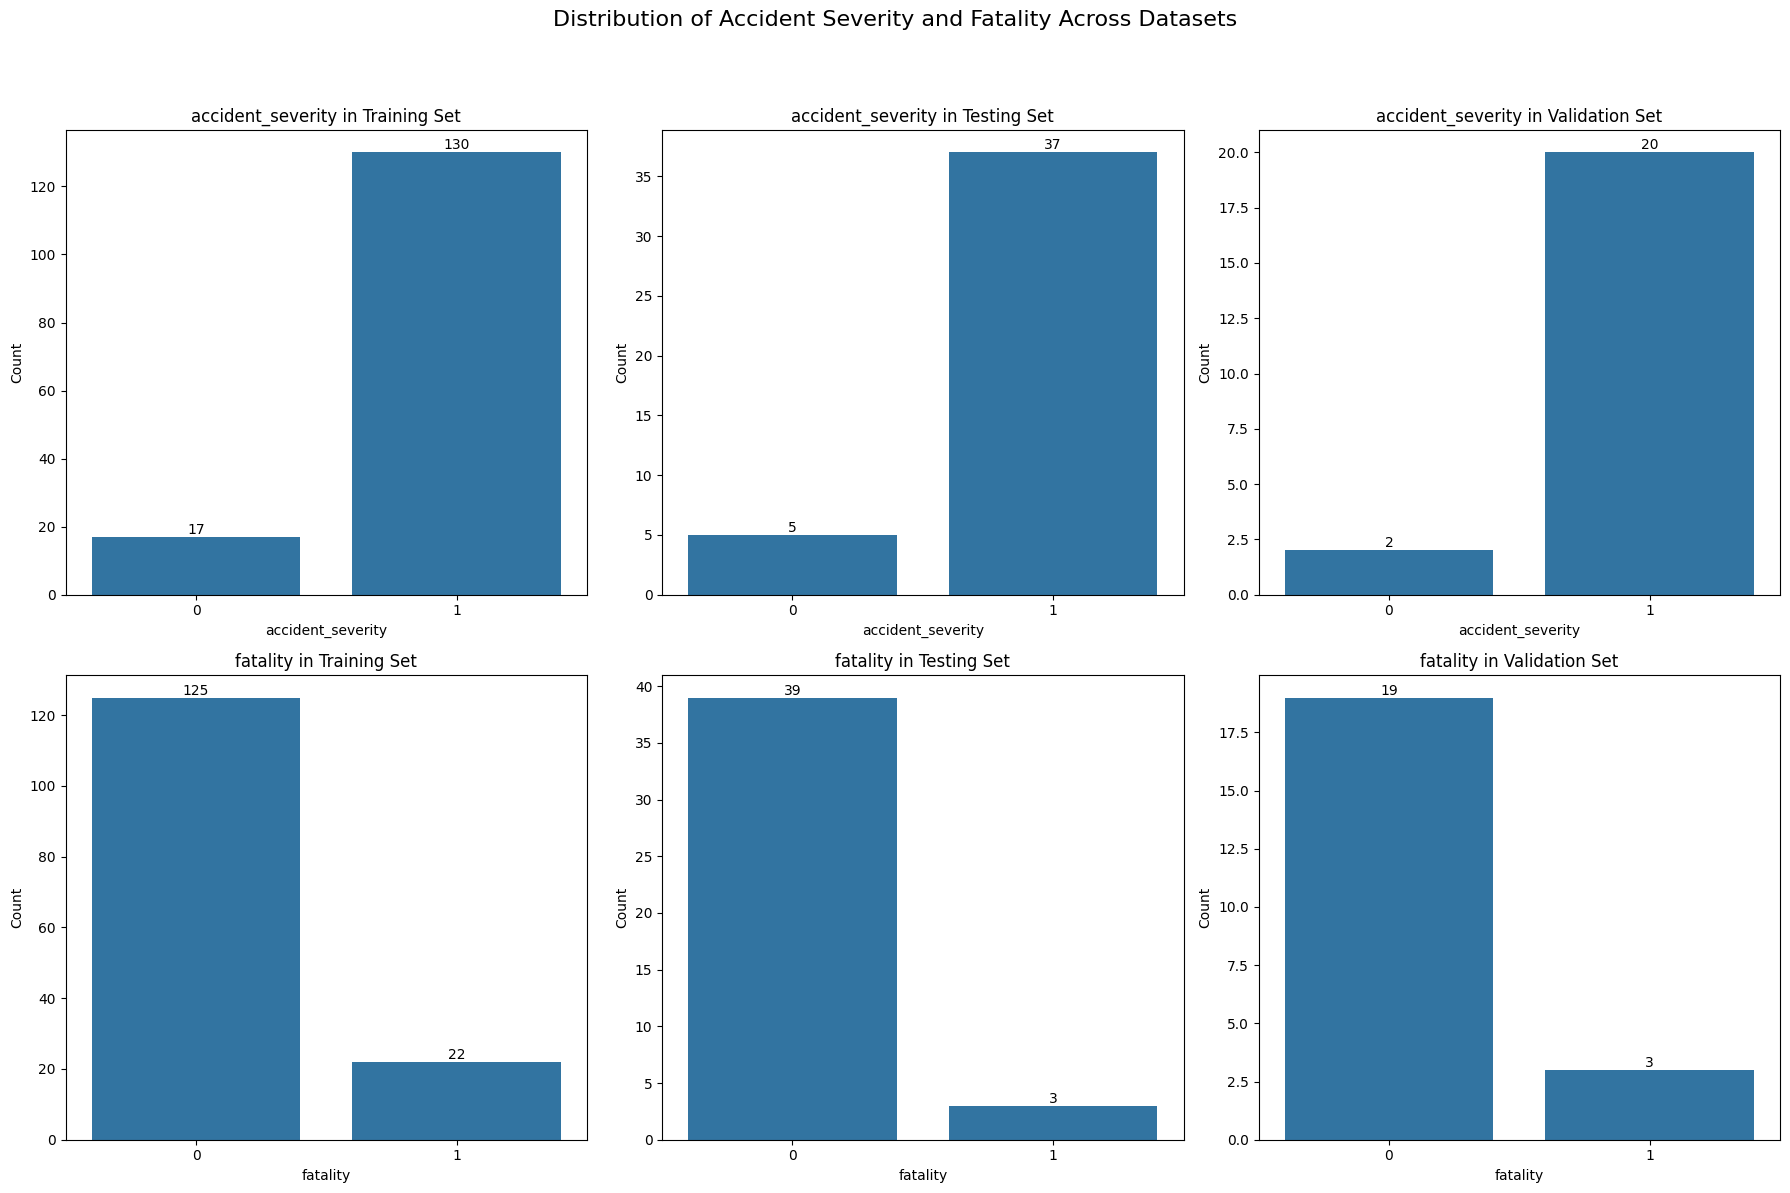

In [23]:
#Visualization of Split data to understand balance in Label results

label_columns = ['accident_severity', 'fatality']

# Define the datasets to iterate through
datasets = {
    'Training': y_train,
    'Testing': y_test,
    'Validation': y_val
}

plt.figure(figsize=(18, 12))
plt.suptitle('Distribution of Accident Severity and Fatality Across Datasets', fontsize=16, y=1.02)

plot_index = 1
for label_col in label_columns:
    for name, data_subset in datasets.items():
        plt.subplot(len(label_columns), len(datasets), plot_index)
        sns.countplot(x=data_subset[label_col])
        plt.title(f'{label_col} in {name} Set')
        plt.xlabel(label_col)
        plt.ylabel('Count')
        for container in plt.gca().containers:
            plt.gca().bar_label(container)
        plot_index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()


STEP 3 --> normalize data

In [24]:
# Initialize StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the training data (fit and transform)
X_train = scaler.fit_transform(X_train)
# Normalize X_test using the scaler fitted on X_train
X_test = scaler.transform(X_test)
# Apply StandardScaler to the validation data (transform only)
X_val = scaler.transform(X_val)

# List of feature sets to normalize
feature_sets = [
    (Xday_train, Xday_test, Xday_val, 'Xday'),
    (Xtime_train, Xtime_test, Xtime_val, 'Xtime'),
    (Xlocation_train, Xlocation_test, Xlocation_val, 'Xlocation'),
    (Xvehicle_train, Xvehicle_test, Xvehicle_val, 'Xvehicle'),
    (Xenv_train, Xenv_test, Xenv_val, 'Xenv'),
    (Xdriver_train, Xdriver_test, Xdriver_val, 'Xdriver'),
    (Xslim_train, Xslim_test, Xslim_val, 'Xslim')
]

for i, (train_set, test_set, val_set, name) in enumerate(feature_sets):
    current_scaler = StandardScaler()

    # Fit on training data for the current feature set
    feature_sets[i] = (current_scaler.fit_transform(train_set), current_scaler.transform(test_set), current_scaler.transform(val_set), name)

    # Update the datasets
    if name == 'Xday':
        Xday_train, Xday_test, Xday_val, _ = feature_sets[i]
    elif name == 'Xtime':
        Xtime_train, Xtime_test, Xtime_val, _ = feature_sets[i]
    elif name == 'Xlocation':
        Xlocation_train, Xlocation_test, Xlocation_val, _ = feature_sets[i]
    elif name == 'Xvehicle':
        Xvehicle_train, Xvehicle_test, Xvehicle_val, _ = feature_sets[i]
    elif name == 'Xenv':
        Xenv_train, Xenv_test, Xenv_val, _ = feature_sets[i]
    elif name == 'Xdriver':
        Xdriver_train, Xdriver_test, Xdriver_val, _ = feature_sets[i]
    elif name == 'Xslim':
        Xslim_train, Xslim_test, Xslim_val, _ = feature_sets[i]


print("\n✓ X_test normalized successfully using the main scaler.")
print("✓ All other grouped feature sets (Xday, Xtime, Xlocation, Xvehicle, Xenv, Xdriver, Xslim) normalized successfully.")

print("\nFirst 5 rows of X_test (normalized):")
print(X_test[:5])

print("\nFirst 5 rows of Xday_train (normalized):")
print(Xday_train[:5])

# Ensure target variables (y_train, y_test, y_val) are integer type for classification
y_test = y_test.astype(int)
y_val = y_val.astype(int)
y_train = y_train.astype(int)
print("\n✓ Target labels (y_train, y_test, y_val) ensured as discrete integers.")



✓ X_test normalized successfully using the main scaler.
✓ All other grouped feature sets (Xday, Xtime, Xlocation, Xvehicle, Xenv, Xdriver, Xslim) normalized successfully.

First 5 rows of X_test (normalized):
[[-0.2236068  -0.44329632  1.68886202 -0.55174151 -0.43639302 -0.37185257
  -0.17770466  1.46601386  0.65190408 -0.08276059 -0.23990406 -0.2236068
   0.92088367  0.25122972 -0.3457404  -0.2236068   1.69364136 -0.2236068
   1.04880885  1.12697474 -0.61141784 -0.23990406 -0.47434165  2.0171677
  -0.68556546 -0.20628425 -0.50636968 -0.6219264  -0.2981424   1.60790729
  -0.45267873 -0.48507125 -0.68556546 -0.36162029 -0.3968379  -0.31147219
  -0.50636968  2.51992063 -0.38078472]
 [-0.2236068  -0.44329632  0.3172448  -0.55174151 -0.43639302 -0.37185257
  -0.17770466 -0.5670431  -1.09045773 -0.08276059 -0.23990406 -0.2236068
   0.92088367 -1.2875523  -0.3457404  -0.2236068  -0.59044378 -0.2236068
  -0.95346259 -1.65654126  1.63554272 -0.23990406 -0.47434165 -0.4957446
   1.45864991 -0.

## 3. Hyperparameter Tuning

###  3.1  k-parameter for classification

In the context of this model search for optimal 'k' number of nearest neighbours that force decision

In [25]:
# Define the list of k values to test
k_values = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,25] # starting at 3 due to general guidance rule [SQR (n) / 2] == SQRT(37)/2 = ~3



# define function to train for different 'k' values, show the Accuracy plot and return a validation list
def knn_validation (X_train, X_test, y_train, y_test, k_values):

    """

    returns a validation list showing accuracy level of each 'k'

    """

    # Store results
    validation_results = {}

    print("\n Training and evaluating KNN Classifier for different k values:")

    for k in k_values:
        # Initialize KNeighborsClassifier with current k
        knn_classifier = KNeighborsClassifier(n_neighbors=k) #, metric='manhattan')

        # Train the model, using the first column of y_train (accident_severity)
        knn_classifier.fit(X_train, y_train)

        # Make predictions on the validation set
        y_pred_test = knn_classifier.predict(X_test)

        # Calculate accuracy, using the first column of y_val (accident_severity)
        accuracy = accuracy_score(y_test, y_pred_test)

        validation_results[k] = accuracy

    # Convert validation_results dictionary to a DataFrame for easier plotting
    plot_df_acc = pd.DataFrame.from_dict(validation_results, orient='index', columns=['accuracy'])
    plot_df_acc.index.name = 'k_value'
    plot_df_acc.reset_index(inplace=True)

    plt.figure(figsize=(10, 5))
    plt.plot(plot_df_acc['k_value'], plot_df_acc['accuracy'], marker='o', linestyle='-')
    plt.title('KNeighborsClassifier Accuracy vs. K Value (Validation Set)')
    plt.xlabel('K Value (n_neighbors)')
    plt.ylabel('Accuracy')
    plt.xticks(plot_df_acc['k_value']) # Ensure all k values are shown on x-axis
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return validation_results

###  3.2  k-parameter for regression

In the context of this model search for optimal 'k' number of nearest neighbours that average regression

In [26]:
# Define the list of k values to test
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,25] # starting at 3 due to general guidance rule [SQR (n) / 2] == SQRT(37)/2 = ~3



# define function to train for different 'k' values, show the Accuracy plot and return a validation list
def Reg_knn_validation (X_train, X_test, y_train, y_test, k_values):

    """

    returns a validation list showing accuracy level of each 'k'

    """

    # Store results
    validation_results = {}

    print("\n Training and evaluating KNN Regressor for different k values:")

    for k in k_values:

        # Initialize KNeighborsRegressor with the chosen k and Euclidean distance
        knn_regressor = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
        # Train the model, using the first column of y_train (accident_severity)
        knn_regressor.fit(X_train, y_train)

        # Make predictions on the validation set
        y_pred_test = knn_regressor.predict(X_test)

        # Evaluate the model on the test set
        mse_test = mean_squared_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)


        validation_results[k] = mse_test

    # Convert validation_results dictionary to a DataFrame for easier plotting
    plot_df_acc = pd.DataFrame.from_dict(validation_results, orient='index', columns=['MSE'])
    plot_df_acc.index.name = 'k_value'
    plot_df_acc.reset_index(inplace=True)

    plt.figure(figsize=(10, 5))
    plt.plot(plot_df_acc['k_value'], plot_df_acc['MSE'], marker='o', linestyle='-')
    plt.title('KNeighbors Regressor MSE vs. K Value (Validation Set)')
    plt.xlabel('K Value (n_neighbors)')
    plt.ylabel('MSE')
    plt.xticks(plot_df_acc['k_value']) # Ensure all k values are shown on x-axis
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return validation_results

## 4. Model Training

Setting master list to summarize findings from each test run.

KPIs to capture for each Experiment:


*    'K Value'
*    'Accuracy'
*    'Class 0 Precision'
*    'Class 1 Precision'
*    'Class 0 Recall'
*    'Class 1 Recall'
*    'Class 0 F1 Score'
*    'Class 1 F1 Score'
*    'AUG'


Where class '0' or '1' refer to the target prediction class, that is;
   - either: Low severity (0) / high severity (1)
   - or:     Non-fatal (0) / fatal (1)




In [27]:
# Create empty sample data
test_data = {
    'Test Name': [],
    'k Value': [],
    'Accuracy': [],
    'Class 0 Precision': [],
    'Class 1 Precision': [],
    'Class 0 Recall': [],
    'Class 1 Recall': [],
    'Class 0 F1 Score': [],
    'Class 1 F1 Score': [],
    'AUG': []
}

# Create DataFrame
kpi_table = pd.DataFrame(test_data)


### 4.1 Training a CLASSIFIER using KNN to determine accident 'Severity'

Features:  all 37 coded features


Label:     Accident Severity (1: High / 0: LOW)



 Training and evaluating KNN Classifier for different k values:


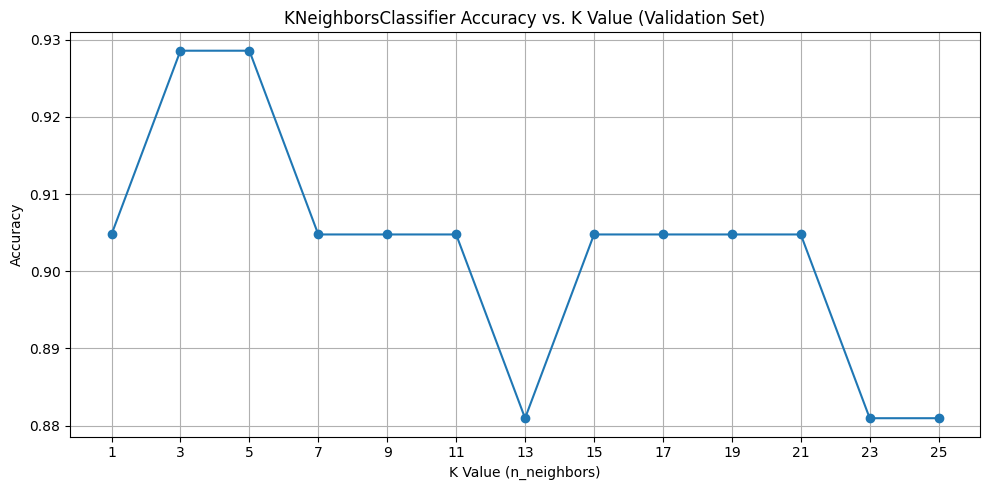


 KNeighborsClassifier training and evaluation completed for all specified k values.

 Optimal k on validation set: 3 with accuracy: 0.9286

 Evaluating KNeighborsClassifier with best k=3 on the Validation dataset:

  Validation Set Evaluation (K = 3)

  Accuracy on test set: 0.8636 



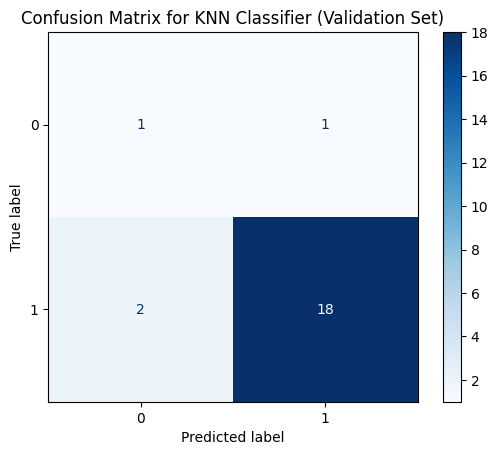

Classification Report for KNN Classifier (Validation Set): 

           Non-Severe Accident  Severe Accident  accuracy  macro avg  \
precision             0.333333         0.947368  0.863636   0.640351   
recall                0.500000         0.900000  0.863636   0.700000   
f1-score              0.400000         0.923077  0.863636   0.661538   
support               2.000000        20.000000  0.863636  22.000000   

           weighted avg  
precision      0.891547  
recall         0.863636  
f1-score       0.875524  
support       22.000000  


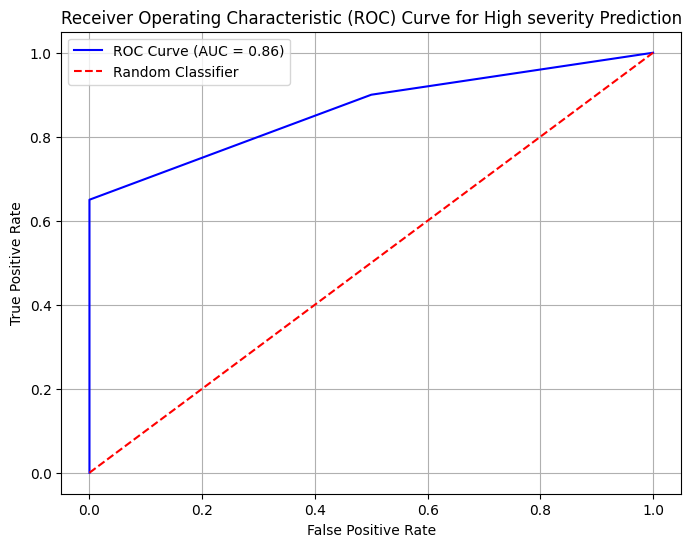


 ROC curve generated successfully. AUC Score: 0.8625


In [28]:
# training model and returning results for multi hyperparamters
knn_results = knn_validation(X_train, X_test, y_train.iloc[:, 0],y_test.iloc[:, 0], k_values)
print(f"\n KNeighborsClassifier training and evaluation completed for all specified k values.")


# Find the best k based on validation accuracy
best_k = max(knn_results, key=knn_results.get)
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_test.fit(X_train, y_train.iloc[:, 0])
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(X_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_val.iloc[:, 0], y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_val.iloc[:,0], y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-Severe Accident', 'Severe Accident']

# Generate and print the classification report
report = classification_report(y_val.iloc[:,0], y_pred_val, target_names=target_names, output_dict=True)

print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

# Get predicted probabilities for the positive class (High severity=1)
y_pred_proba = knn_classifier_test.predict_proba(X_val)[:, 1] #changed to '1' to measure

# Get true labels
y_true = y_val.iloc[:, 0]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.1',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])

kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)


Result:
 - Good performance in predicting 'high severity' cases with a good balance in Precision and Recall. This is seen in an `f1 score of 0.92`
 - However model is not adequate for predicting low severity cases as f1 score is very low is very low.
 - Seems model is prediciting 'high severity' in most cases due to imbalance of data

 Note:
 This performance was acheived after changing the PDF of the split data set to improve balancing of low/high severe cases we see an improved result.


### 4.2 Training a CLASSIFIER using KNN to determine 'Accident Fatality'

Features:  all 37 coded features


Label:     Accident Fatality (1: yes / 0: No)


 Training and evaluating KNN Classifier for different k values:


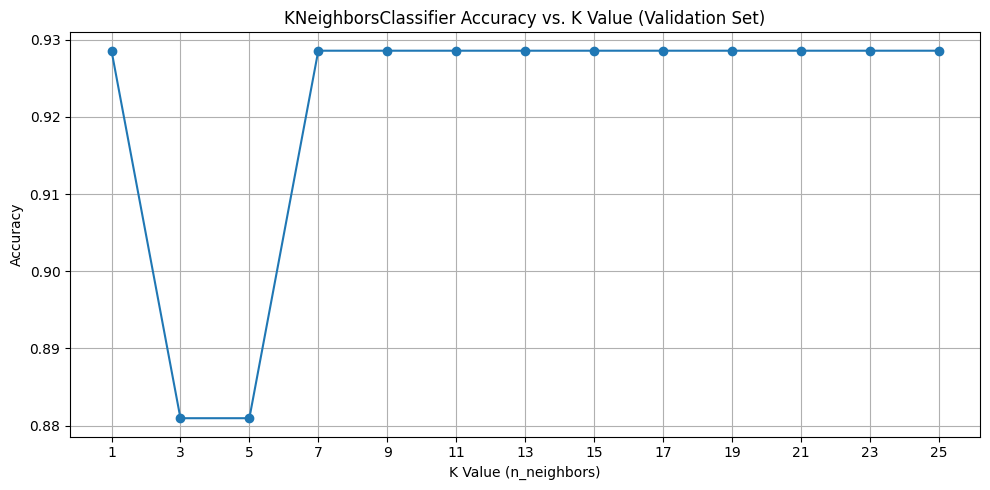


 KNeighborsClassifier training and evaluation completed for all specified k values.

 Optimal k on validation set: 1 with accuracy: 0.9286

 Evaluating KNeighborsClassifier with best k=1 on the Validation dataset:

  Validation Set Evaluation (K = 1)

  Accuracy on test set: 0.8182 



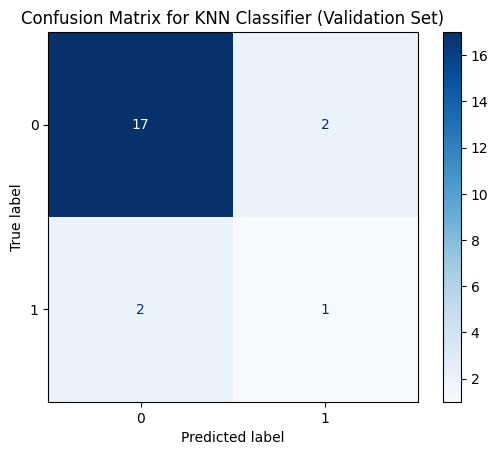

Classification Report for KNN Classifier (Validation Set): 

           Non-fatal     Fatal  accuracy  macro avg  weighted avg
precision   0.894737  0.333333  0.818182   0.614035      0.818182
recall      0.894737  0.333333  0.818182   0.614035      0.818182
f1-score    0.894737  0.333333  0.818182   0.614035      0.818182
support    19.000000  3.000000  0.818182  22.000000     22.000000


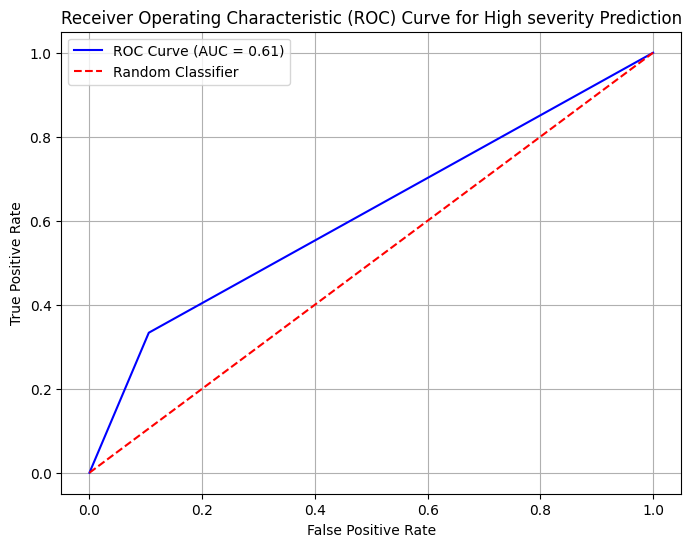


 ROC curve generated successfully. AUC Score: 0.6140


In [29]:
# training model and returning results for multi hyperparamters
knn_results = knn_validation(X_train, X_test, y_train.iloc[:, 1],y_test.iloc[:, 1], k_values)
print(f"\n KNeighborsClassifier training and evaluation completed for all specified k values.")


# Find the best k based on validation accuracy
best_k = max(knn_results, key=knn_results.get)
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_test.fit(X_train, y_train.iloc[:, 1])
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(X_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_val.iloc[:, 1], y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_val.iloc[:,1], y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-fatal', 'Fatal']

# Generate and print the classification report
report = classification_report(y_val.iloc[:,1], y_pred_val, target_names=target_names, output_dict=True)
print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

# Get predicted probabilities for the positive class (Fatal =1)
y_pred_proba = knn_classifier_test.predict_proba(X_val)[:, 1]

# Get true labels
y_true = y_val.iloc[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.2',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])
kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)


Model is predicting 89% non-fatal cases however only 33% of fatal cases. Thus returns very poor f1 score and recall for fatal incidents

### 4.3 Training a CLASSIFIER using KNN to determine accident 'Severity' using a reduced feature set

Features:  slim version : 22 features


Label:     Accident Severity (1: High / 0: LOW)


 Training and evaluating KNN Classifier for different k values:


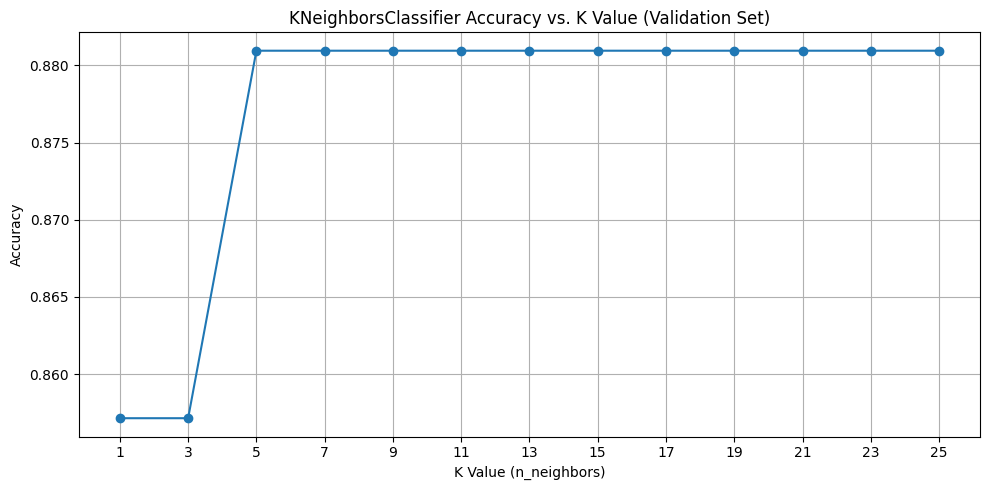


 KNeighborsClassifier training and evaluation completed for all specified k values.

 Optimal k on validation set: 5 with accuracy: 0.8810

 Evaluating KNeighborsClassifier with best k=5 on the Validation dataset:

  Validation Set Evaluation (K = 5)

  Accuracy on test set: 0.9091 



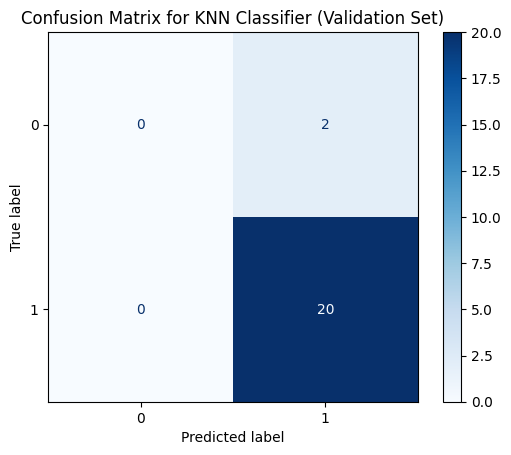

Classification Report for KNN Classifier (Validation Set): 

           Non-Severe Accident  Severe Accident  accuracy  macro avg  \
precision                  0.0         0.909091  0.909091   0.454545   
recall                     0.0         1.000000  0.909091   0.500000   
f1-score                   0.0         0.952381  0.909091   0.476190   
support                    2.0        20.000000  0.909091  22.000000   

           weighted avg  
precision      0.826446  
recall         0.909091  
f1-score       0.865801  
support       22.000000  


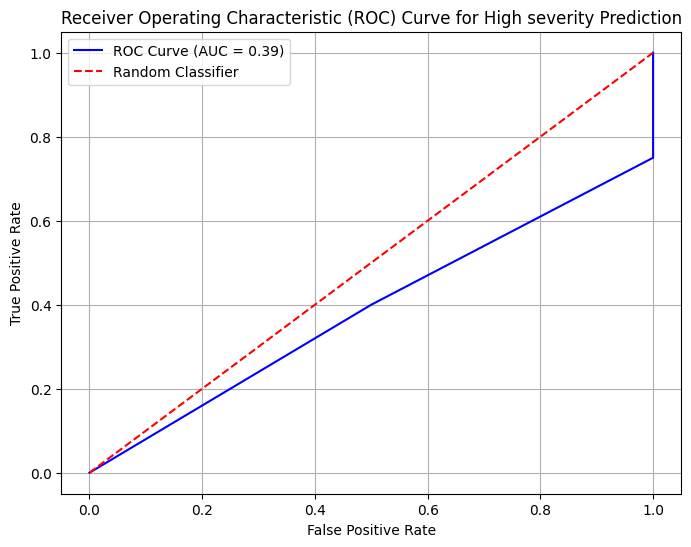


 ROC curve generated successfully. AUC Score: 0.3875


In [30]:
# training model and returning results for multi hyperparamters
knn_results = knn_validation(Xslim_train, Xslim_test, y_train.iloc[:, 0],y_test.iloc[:, 0], k_values)
print(f"\n KNeighborsClassifier training and evaluation completed for all specified k values.")


# Find the best k based on validation accuracy
best_k = max(knn_results, key=knn_results.get)
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_test.fit(Xslim_train, y_train.iloc[:, 0])
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(Xslim_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_val.iloc[:, 0], y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_val.iloc[:,0], y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-Severe Accident', 'Severe Accident']

# Generate and print the classification report
report = classification_report(y_val.iloc[:,0], y_pred_val, target_names=target_names, output_dict=True)

print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

#Get predicted probabilities for the positive class (High severity=1)
y_pred_proba = knn_classifier_test.predict_proba(Xslim_val)[:, 1]

# Get true labels
y_true = y_val.iloc[:, 0]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.3',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])
kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)


Result: Very poor prerfomranced based on F1-score and ROC.


### 4.4 Training a CLASSIFIER using KNN to determine 'Accident Fatality' using a reduced feature set

Features:  slim version : 22 features


Label:     Accident Fatality (1: yes / 0: No)


 Training and evaluating KNN Classifier for different k values:


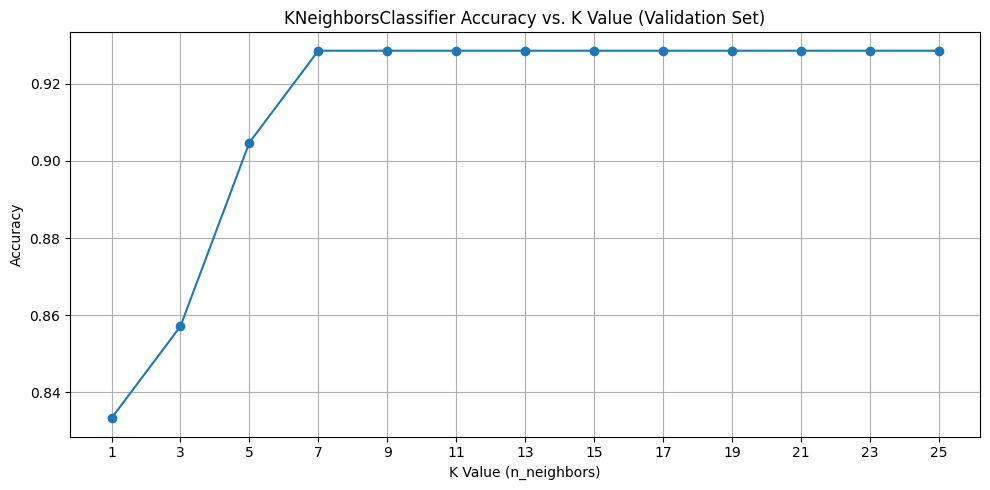


 KNeighborsClassifier training and evaluation completed for all specified k values.

 Optimal k on validation set: 7 with accuracy: 0.9286

 Evaluating KNeighborsClassifier with best k=7 on the Validation dataset:

  Validation Set Evaluation (K = 7)

  Accuracy on test set: 0.8636 



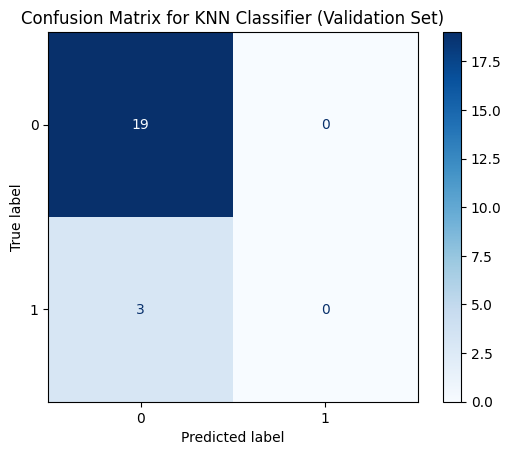

Classification Report for KNN Classifier (Validation Set): 

           Non-fatal  Fatal  accuracy  macro avg  weighted avg
precision   0.863636    0.0  0.863636   0.431818      0.745868
recall      1.000000    0.0  0.863636   0.500000      0.863636
f1-score    0.926829    0.0  0.863636   0.463415      0.800443
support    19.000000    3.0  0.863636  22.000000     22.000000


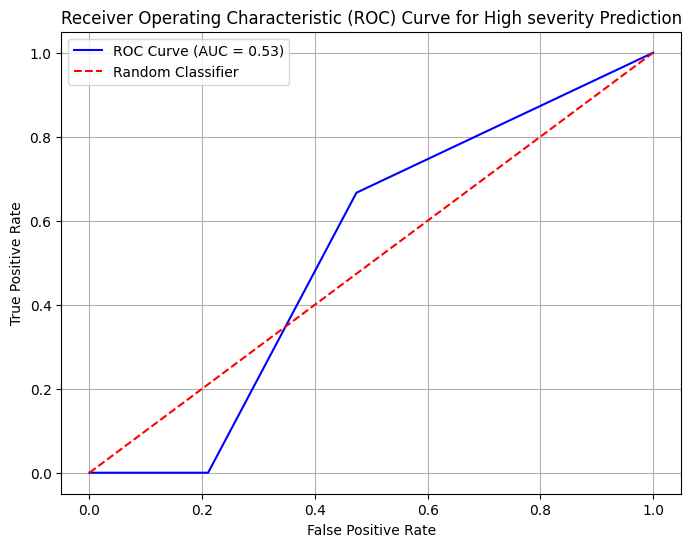


 ROC curve generated successfully. AUC Score: 0.5263


In [31]:
# training model and returning results for multi hyperparamters
knn_results = knn_validation(Xslim_train, Xslim_test, y_train.iloc[:, 1],y_test.iloc[:, 1], k_values)
print(f"\n KNeighborsClassifier training and evaluation completed for all specified k values.")


# Find the best k based on validation accuracy
best_k = max(knn_results, key=knn_results.get)
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_test.fit(Xslim_train, y_train.iloc[:, 1])
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(Xslim_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_val.iloc[:, 1], y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_val.iloc[:,1], y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-fatal', 'Fatal']

# Generate and print the classification report
report = classification_report(y_val.iloc[:,1], y_pred_val, target_names=target_names, output_dict=True)

print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

#Get predicted probabilities for the positive class (Fatal=1)
y_pred_proba = knn_classifier_test.predict_proba(Xslim_val)[:, 1]

# Get true labels
y_true = y_val.iloc[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.4',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])
kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)

Result : Far off result from predicitng any fatal accident base on the 22 input features


### 4.5 Training a CLASSIFIER using KNN to determine accident 'Severity' based on vehicles involved

Features:  selective features
            - Xvehicle dataset


Label:     Accident Severity (1: High / 0: LOW)


 Training and evaluating KNN Classifier for different k values:


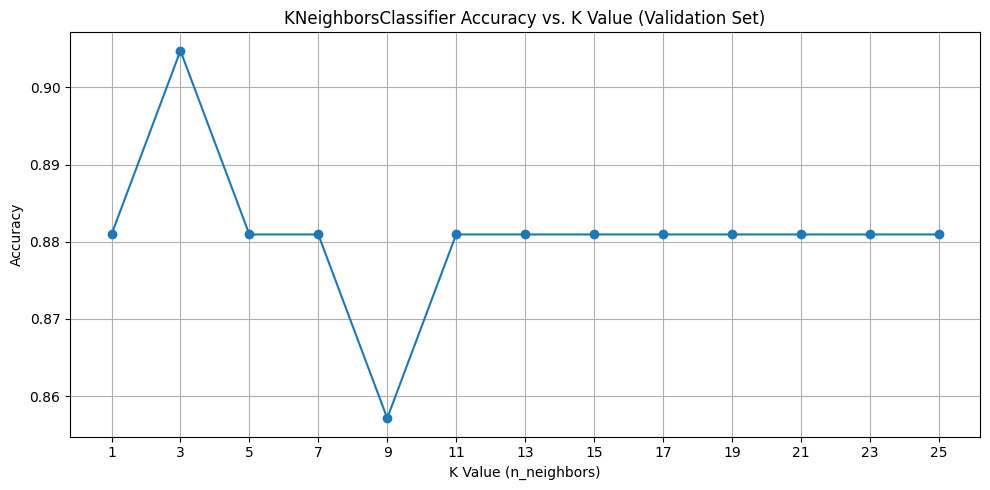


 KNeighborsClassifier training and evaluation completed for all specified k values.

 Optimal k on validation set: 3 with accuracy: 0.9048

 Evaluating KNeighborsClassifier with best k=3 on the Validation dataset:

  Validation Set Evaluation (K = 3)

  Accuracy on test set: 0.8636 



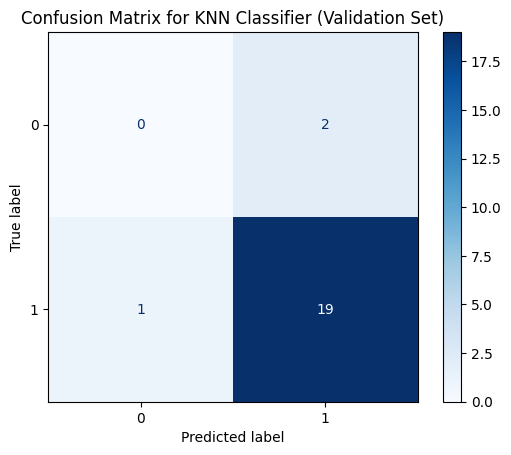

Classification Report for KNN Classifier (Validation Set): 

           Non-Severe Accident  Severe Accident  accuracy  macro avg  \
precision                  0.0         0.904762  0.863636   0.452381   
recall                     0.0         0.950000  0.863636   0.475000   
f1-score                   0.0         0.926829  0.863636   0.463415   
support                    2.0        20.000000  0.863636  22.000000   

           weighted avg  
precision      0.822511  
recall         0.863636  
f1-score       0.842572  
support       22.000000  


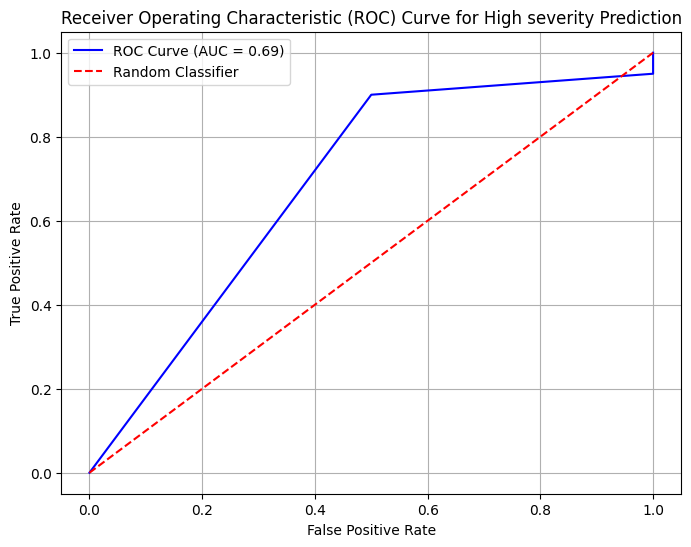


 ROC curve generated successfully. AUC Score: 0.6875


In [32]:
# training model and returning results for multiple hyperparamters
knn_results = knn_validation(Xvehicle_train, Xvehicle_test, y_train.iloc[:, 0],y_test.iloc[:, 0], k_values)
print(f"\n KNeighborsClassifier training and evaluation completed for all specified k values.")


# Find the best k based on validation accuracy
best_k = max(knn_results, key=knn_results.get)
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_test.fit(Xvehicle_train, y_train.iloc[:, 0])
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(Xvehicle_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_val.iloc[:, 0], y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_val.iloc[:,0], y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-Severe Accident', 'Severe Accident']

# Generate and print the classification report
report = classification_report(y_val.iloc[:,0], y_pred_val, target_names=target_names, output_dict=True)

print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

#Get predicted probabilities for the positive class (High severity=1)
y_pred_proba = knn_classifier_test.predict_proba(Xvehicle_val)[:, 1]

# Get true labels
y_true = y_val.iloc[:, 0]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.5',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])
kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)

### 4.6 Training a CLASSIFIER using KNN to determine accident 'Fatality' based on vehicles involved

Features:  selective features
            - Xvehicle dataset


Accident Fatality (1: yes / 0: No)


 Training and evaluating KNN Classifier for different k values:


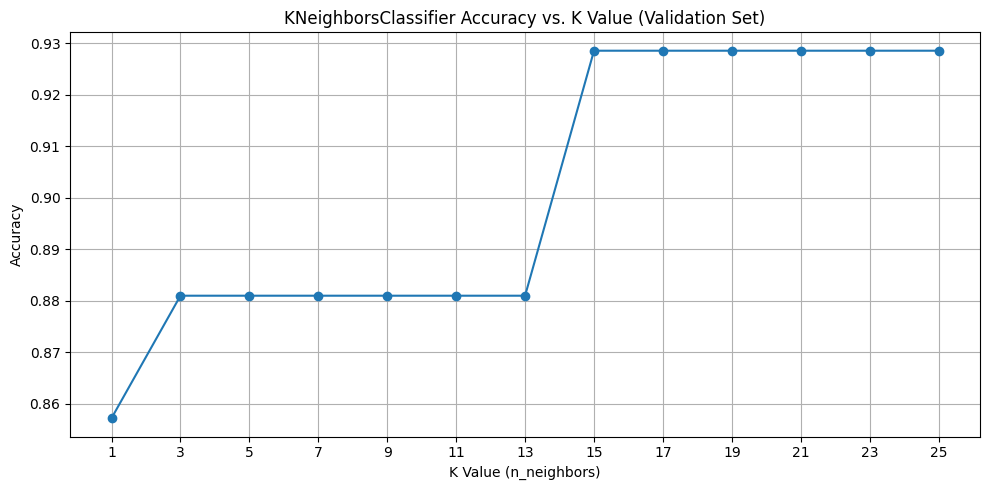


 KNeighborsClassifier training and evaluation completed for all specified k values.

 Optimal k on validation set: 15 with accuracy: 0.9286

 Evaluating KNeighborsClassifier with best k=15 on the Validation dataset:

  Validation Set Evaluation (K = 15)

  Accuracy on test set: 0.8636 



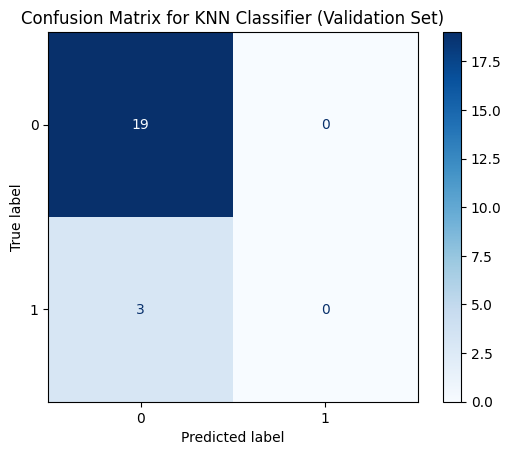

Classification Report for KNN Classifier (Validation Set): 

           Non-fatal  Fatal  accuracy  macro avg  weighted avg
precision   0.863636    0.0  0.863636   0.431818      0.745868
recall      1.000000    0.0  0.863636   0.500000      0.863636
f1-score    0.926829    0.0  0.863636   0.463415      0.800443
support    19.000000    3.0  0.863636  22.000000     22.000000


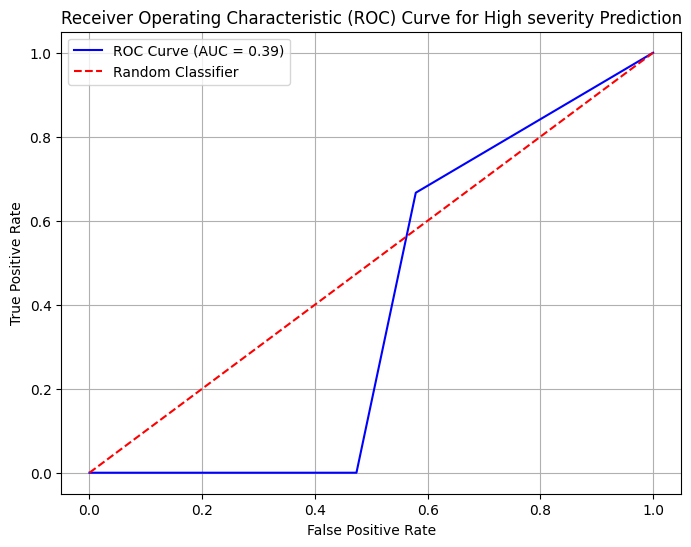


 ROC curve generated successfully. AUC Score: 0.3860


In [33]:
# training model and returning results for multi hyperparamters
knn_results = knn_validation(Xvehicle_train, Xvehicle_test, y_train.iloc[:, 1],y_test.iloc[:, 1], k_values)
print(f"\n KNeighborsClassifier training and evaluation completed for all specified k values.")

# Find the best k based on validation accuracy
best_k = max(knn_results, key=knn_results.get)
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_test.fit(Xvehicle_train, y_train.iloc[:, 1])
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(Xvehicle_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_val.iloc[:, 1], y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_val.iloc[:,1], y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-fatal', 'Fatal']

# Generate and print the classification report
report = classification_report(y_val.iloc[:,1], y_pred_val, target_names=target_names, output_dict=True)

print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

#Get predicted probabilities for the positive class (Fatal=1)
y_pred_proba = knn_classifier_test.predict_proba(Xvehicle_val)[:, 1]

# Get true labels
y_true = y_val.iloc[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.6',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])
kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)

### 4.7 Training a CLASSIFIER using KNN to determine accident 'Severity' based on location of accident and day of accident

Features:  selective features
            - Xlocation dataset
            - Xday dataset


Label:     Accident Severity (1: High / 0: LOW)


 Training and evaluating KNN Classifier for different k values:


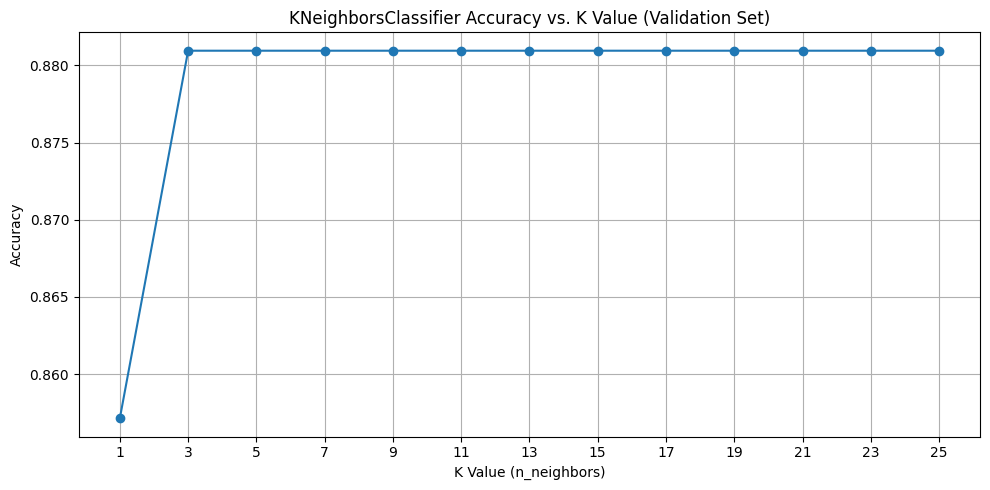


 KNeighborsClassifier training and evaluation completed for all specified k values.

 Optimal k on validation set: 3 with accuracy: 0.8810

 Evaluating KNeighborsClassifier with best k=3 on the Validation dataset:

  Validation Set Evaluation (K = 3)

  Accuracy on test set: 0.9091 



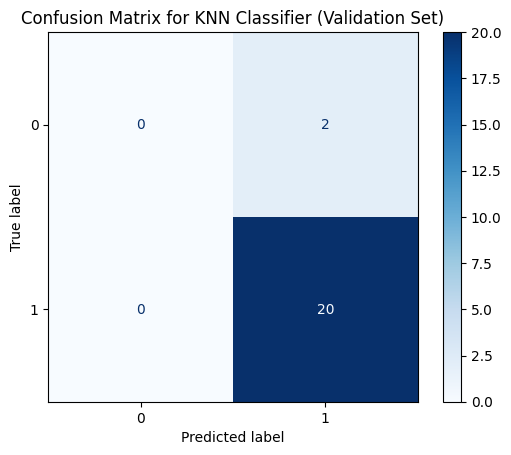

Classification Report for KNN Classifier (Validation Set): 

           Non-Severe Accident  Severe Accident  accuracy  macro avg  \
precision                  0.0         0.909091  0.909091   0.454545   
recall                     0.0         1.000000  0.909091   0.500000   
f1-score                   0.0         0.952381  0.909091   0.476190   
support                    2.0        20.000000  0.909091  22.000000   

           weighted avg  
precision      0.826446  
recall         0.909091  
f1-score       0.865801  
support       22.000000  


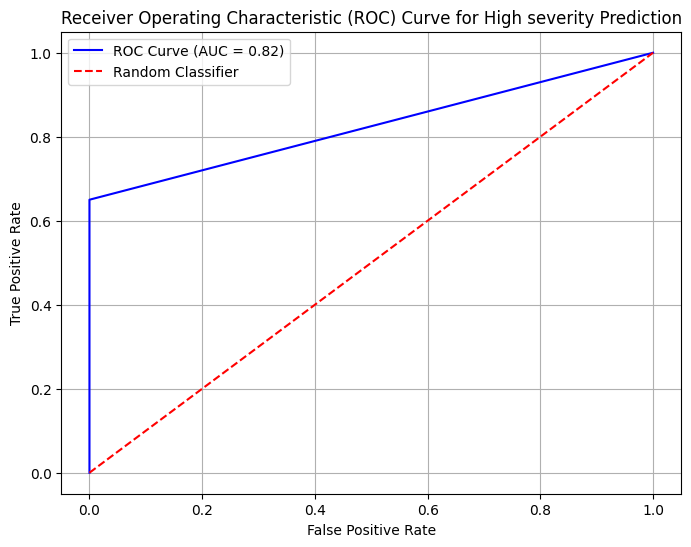


 ROC curve generated successfully. AUC Score: 0.8250


In [34]:
# define features
X_mix_train = np.hstack([Xday_train, Xlocation_train])
X_mix_test = np.hstack([Xday_test, Xlocation_test])
X_mix_val = np.hstack([Xday_val, Xlocation_val])


# training model and returning results for multiple hyperparamters
knn_results = knn_validation(X_mix_train, X_mix_test, y_train.iloc[:, 0],y_test.iloc[:, 0], k_values)
print(f"\n KNeighborsClassifier training and evaluation completed for all specified k values.")


# Find the best k based on validation accuracy
best_k = max(knn_results, key=knn_results.get)
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_test.fit(X_mix_train, y_train.iloc[:, 0])
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(X_mix_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_val.iloc[:, 0], y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_val.iloc[:,0], y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-Severe Accident', 'Severe Accident']

# Generate and print the classification report
report = classification_report(y_val.iloc[:,0], y_pred_val, target_names=target_names, output_dict=True)

print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

#Get predicted probabilities for the positive class (High severity=1)
y_pred_proba = knn_classifier_test.predict_proba(X_mix_val)[:, 1]

# Get true labels
y_true = y_val.iloc[:, 0]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.7',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])
kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)

### 4.8 Training a CLASSIFIER using KNN to determine accident 'Fatality' based on location of accident and day of accident

Features:  selective features
            - Xlocation dataset
            - Xday dataset


Accident Fatality (1: yes / 0: No)


 Training and evaluating KNN Classifier for different k values:


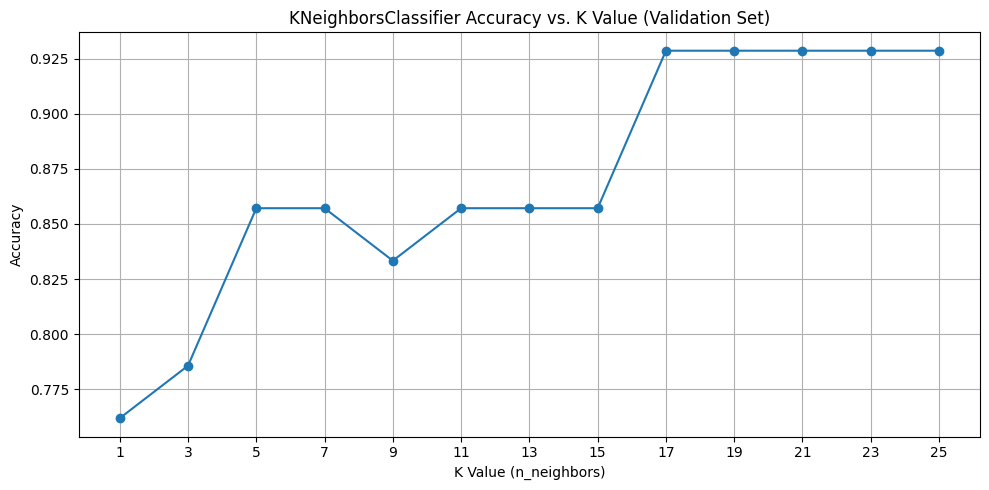


 KNeighborsClassifier training and evaluation completed for all specified k values.

 Optimal k on validation set: 17 with accuracy: 0.9286

 Evaluating KNeighborsClassifier with best k=17 on the Validation dataset:

  Validation Set Evaluation (K = 17)

  Accuracy on test set: 0.8636 



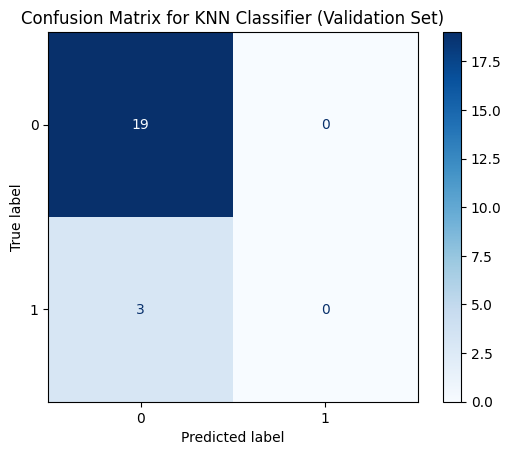

Classification Report for KNN Classifier (Validation Set): 

           Non-fatal  Fatal  accuracy  macro avg  weighted avg
precision   0.863636    0.0  0.863636   0.431818      0.745868
recall      1.000000    0.0  0.863636   0.500000      0.863636
f1-score    0.926829    0.0  0.863636   0.463415      0.800443
support    19.000000    3.0  0.863636  22.000000     22.000000


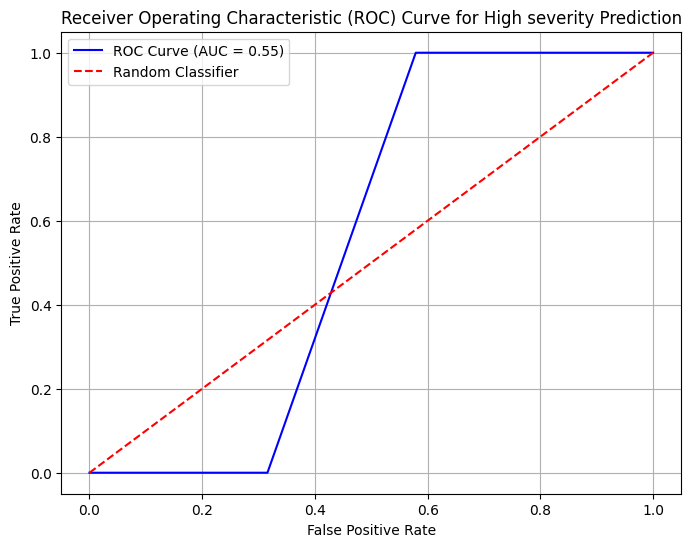


 ROC curve generated successfully. AUC Score: 0.5526


In [35]:
# define features
X_mix_train = np.hstack([Xday_train, Xlocation_train])
X_mix_test = np.hstack([Xday_test, Xlocation_test])
X_mix_val = np.hstack([Xday_val, Xlocation_val])


# training model and returning results for multi hyperparamters
knn_results = knn_validation(X_mix_train, X_mix_test, y_train.iloc[:, 1],y_test.iloc[:, 1], k_values)
print(f"\n KNeighborsClassifier training and evaluation completed for all specified k values.")


# Find the best k based on validation accuracy
best_k = max(knn_results, key=knn_results.get)
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_test.fit(X_mix_train, y_train.iloc[:, 1])
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(X_mix_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_val.iloc[:, 1], y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_val.iloc[:,1], y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-fatal', 'Fatal']

# Generate and print the classification report
report = classification_report(y_val.iloc[:,1], y_pred_val, target_names=target_names, output_dict=True)

print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

#Get predicted probabilities for the positive class (Fatal=1)
y_pred_proba = knn_classifier_test.predict_proba(X_mix_val)[:, 1]

# Get true labels
y_true = y_val.iloc[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.8',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])
kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)

### 4.9 Training a CLASSIFIER using KNN to determine accident 'Severity' based on day and time of accident

Features:  selective features
            - Xtime dataset
            - Xday dataset


Label:     Accident Severity (1: High / 0: LOW)


 Training and evaluating KNN Classifier for different k values:


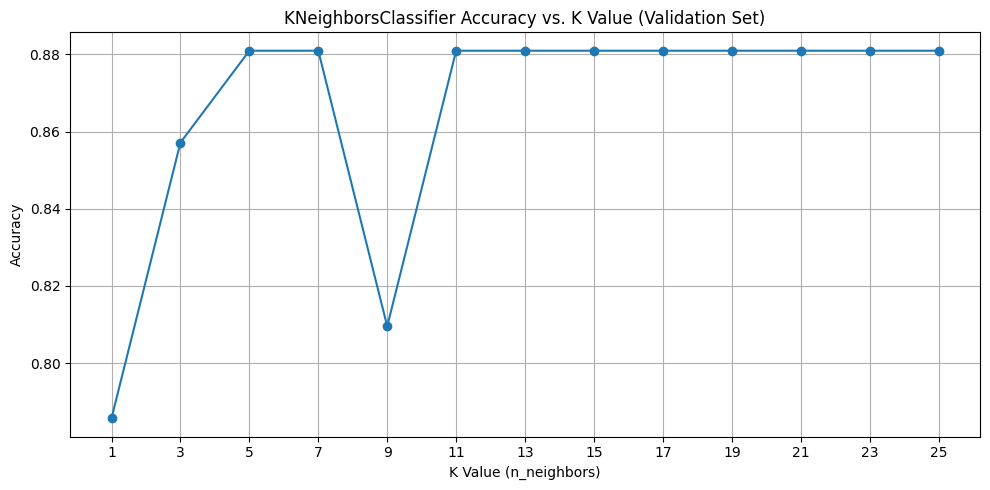


 KNeighborsClassifier training and evaluation completed for all specified k values.

 Optimal k on validation set: 5 with accuracy: 0.8810

 Evaluating KNeighborsClassifier with best k=5 on the Validation dataset:

  Validation Set Evaluation (K = 5)

  Accuracy on test set: 0.9091 



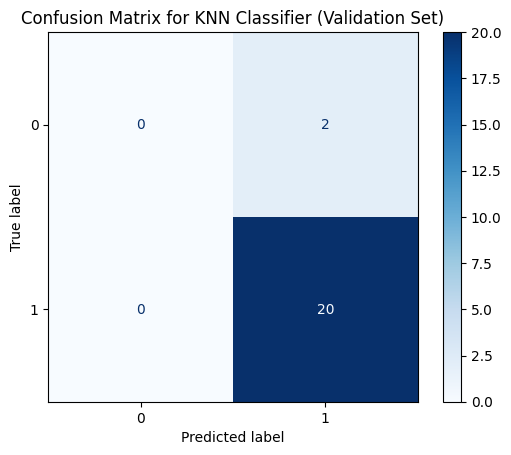

Classification Report for KNN Classifier (Validation Set): 

           Non-Severe Accident  Severe Accident  accuracy  macro avg  \
precision                  0.0         0.909091  0.909091   0.454545   
recall                     0.0         1.000000  0.909091   0.500000   
f1-score                   0.0         0.952381  0.909091   0.476190   
support                    2.0        20.000000  0.909091  22.000000   

           weighted avg  
precision      0.826446  
recall         0.909091  
f1-score       0.865801  
support       22.000000  


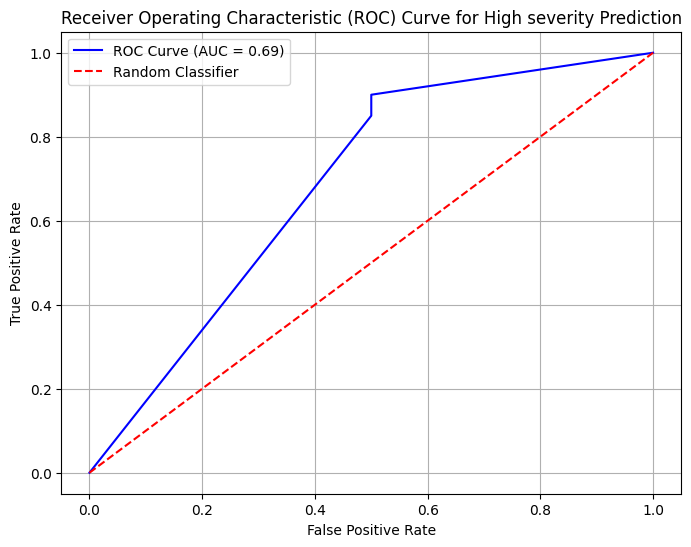


 ROC curve generated successfully. AUC Score: 0.6875


In [36]:
# define features
X_mix_train = np.hstack([Xday_train,Xtime_train])
X_mix_test = np.hstack([Xday_test, Xtime_test])
X_mix_val = np.hstack([Xday_val, Xtime_val])


# training model and returning results for multiple hyperparamters
knn_results = knn_validation(X_mix_train, X_mix_test, y_train.iloc[:, 0],y_test.iloc[:, 0], k_values)
print(f"\n KNeighborsClassifier training and evaluation completed for all specified k values.")


# Find the best k based on validation accuracy
best_k = max(knn_results, key=knn_results.get)
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_test.fit(X_mix_train, y_train.iloc[:, 0])
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(X_mix_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_val.iloc[:, 0], y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_val.iloc[:,0], y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-Severe Accident', 'Severe Accident']

# Generate and print the classification report
report = classification_report(y_val.iloc[:,0], y_pred_val, target_names=target_names, output_dict=True)

print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

#Get predicted probabilities for the positive class (High severity=1)
y_pred_proba = knn_classifier_test.predict_proba(X_mix_val)[:, 1]

# Get true labels
y_true = y_val.iloc[:, 0]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.9',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])
kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)

### 4.10 Training a CLASSIFIER using KNN to determine accident 'Fatality' based on day and time of the accident

Features:  selective features
            - Xtime dataset
            - Xday dataset


Accident Fatality (1: yes / 0: No)


 Training and evaluating KNN Classifier for different k values:


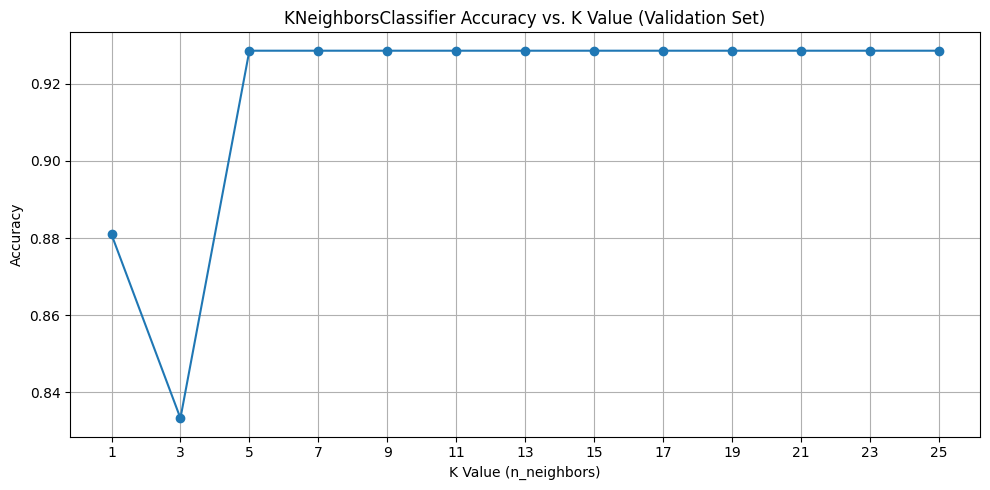


 KNeighborsClassifier training and evaluation completed for all specified k values.

 Optimal k on validation set: 5 with accuracy: 0.9286

 Evaluating KNeighborsClassifier with best k=5 on the Validation dataset:

  Validation Set Evaluation (K = 5)

  Accuracy on test set: 0.8636 



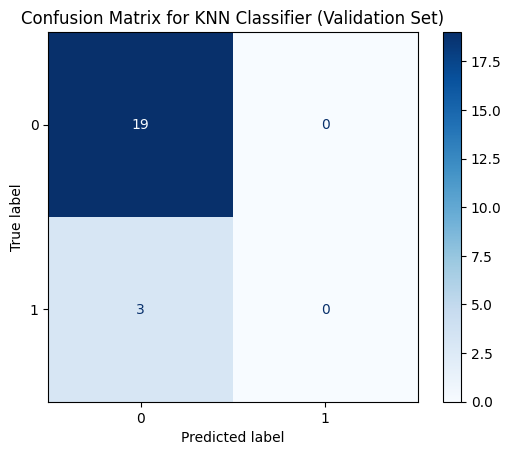

Classification Report for KNN Classifier (Validation Set): 

           Non-fatal  Fatal  accuracy  macro avg  weighted avg
precision   0.863636    0.0  0.863636   0.431818      0.745868
recall      1.000000    0.0  0.863636   0.500000      0.863636
f1-score    0.926829    0.0  0.863636   0.463415      0.800443
support    19.000000    3.0  0.863636  22.000000     22.000000


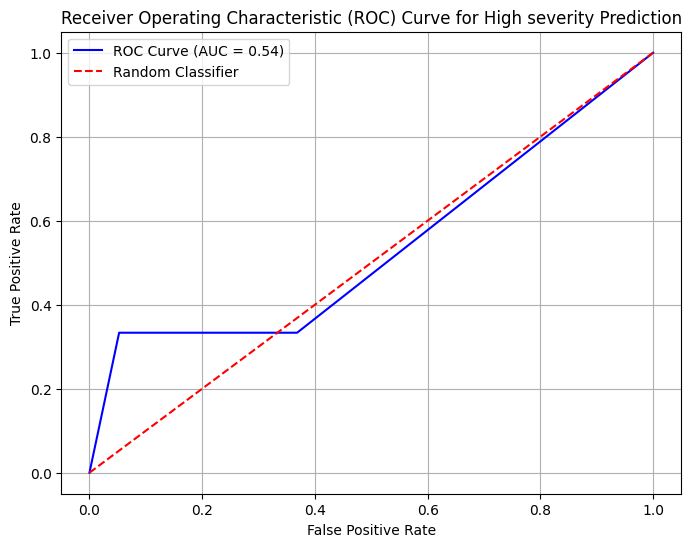


 ROC curve generated successfully. AUC Score: 0.5351


In [37]:
# define features
X_mix_train = np.hstack([Xday_train,Xtime_train])
X_mix_test = np.hstack([Xday_test, Xtime_test])
X_mix_val = np.hstack([Xday_val, Xtime_val])

# training model and returning results for multi hyperparamters
knn_results = knn_validation(X_mix_train, X_mix_test, y_train.iloc[:, 1],y_test.iloc[:, 1], k_values)
print(f"\n KNeighborsClassifier training and evaluation completed for all specified k values.")


# Find the best k based on validation accuracy
best_k = max(knn_results, key=knn_results.get)
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_test.fit(X_mix_train, y_train.iloc[:, 1])
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(X_mix_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_val.iloc[:, 1], y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_val.iloc[:,1], y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-fatal', 'Fatal']

# Generate and print the classification report
report = classification_report(y_val.iloc[:,1], y_pred_val, target_names=target_names, output_dict=True)

print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

#Get predicted probabilities for the positive class (Fatal=1)
y_pred_proba = knn_classifier_test.predict_proba(X_mix_val)[:, 1]

# Get true labels
y_true = y_val.iloc[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.10',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])
kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)

### 4.11 Training a CLASSIFIER using KNN to determine 'Accident Severity' based on an agressively reduced feature set

Features:  selective 10 features


Accident Fatality (1: yes / 0: No)

Overview of dataframe prepared for model training
Shape of X (features): 211 rows, 10 columns represents all injected features

 Training and evaluating KNN Classifier for different k values:


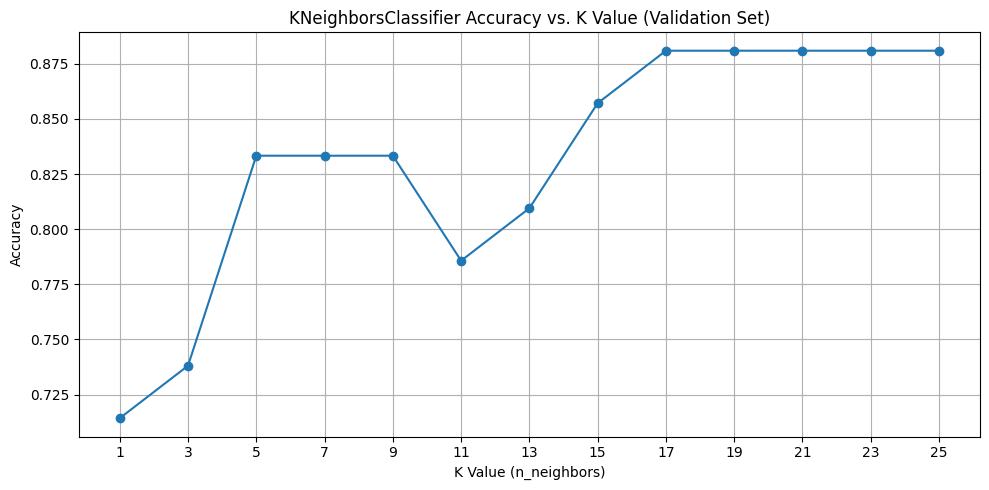


 KNeighborsClassifier training and evaluation completed for all specified k values.

 Optimal k on validation set: 17 with accuracy: 0.8810

 Evaluating KNeighborsClassifier with best k=17 on the Validation dataset:

  Validation Set Evaluation (K = 17)

  Accuracy on test set: 0.9091 



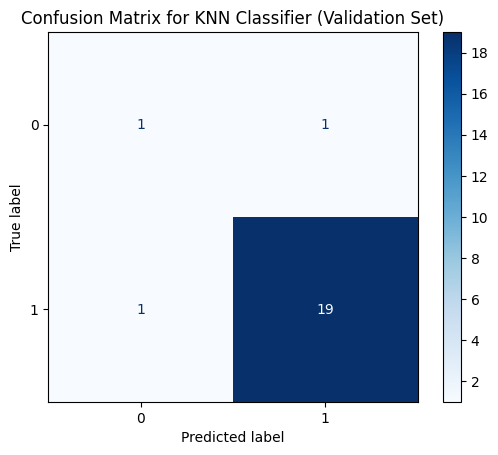

Classification Report for KNN Classifier (Validation Set): 

           Non-Severe Accident  Severe Accident  accuracy  macro avg  \
precision                  0.5             0.95  0.909091      0.725   
recall                     0.5             0.95  0.909091      0.725   
f1-score                   0.5             0.95  0.909091      0.725   
support                    2.0            20.00  0.909091     22.000   

           weighted avg  
precision      0.909091  
recall         0.909091  
f1-score       0.909091  
support       22.000000  


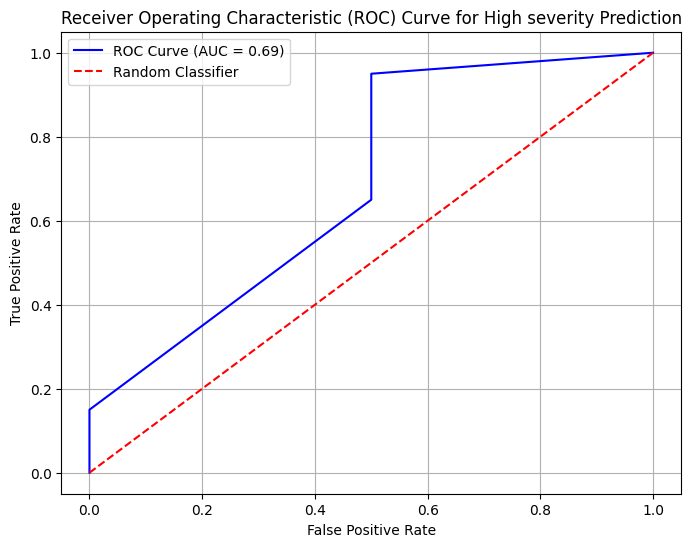


 ROC curve generated successfully. AUC Score: 0.6875


In [38]:
#Build feature set
X10 = df[['num_drivers_under_18','num_drivers_65_plus','street_type_primary', 'street_type_trunk', 'num_vehicle_motorbike', 'is_raining',
          'traffic_level_encoded','is_weekend','accident_time_category_night','accident_time_category_early_morning']]
#the slim version of the feture set is a biased version based on literature review to reduce feature set to avoid curse of dimensionality.

print("Overview of dataframe prepared for model training")
print(f"Shape of X (features): {X10.shape[0]} rows, {X10.shape[1]} columns represents all injected features")

# train/ test/validate dataset split
X10_train, X10_temp = train_test_split(X10, test_size=0.3, random_state=43)
X10_test, X10_val = train_test_split(X10_temp, test_size=0.33333333, random_state=43)

#normalizing data
# Apply StandardScaler to the training data (fit and transform)
X10_train = scaler.fit_transform(X10_train)
# Normalize X_test using the scaler fitted on X_train
X10_test = scaler.transform(X10_test)
# Apply StandardScaler to the validation data (transform only)
X10_val = scaler.transform(X10_val)

# define features
X_mix_train = np.hstack([X10_train])
X_mix_test = np.hstack([X10_test])
X_mix_val = np.hstack([X10_val])

# training model and returning results for multiple hyperparamters
knn_results = knn_validation(X_mix_train, X_mix_test, y_train.iloc[:, 0],y_test.iloc[:, 0], k_values)
print(f"\n KNeighborsClassifier training and evaluation completed for all specified k values.")


# Find the best k based on validation accuracy
best_k = max(knn_results, key=knn_results.get)
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_test.fit(X_mix_train, y_train.iloc[:, 0])
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(X_mix_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_val.iloc[:, 0], y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_val.iloc[:,0], y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-Severe Accident', 'Severe Accident']

# Generate and print the classification report
report = classification_report(y_val.iloc[:,0], y_pred_val, target_names=target_names, output_dict=True)

print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

#Get predicted probabilities for the positive class (High severity=1)
y_pred_proba = knn_classifier_test.predict_proba(X_mix_val)[:, 1]

# Get true labels
y_true = y_val.iloc[:, 0]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.11',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])
kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)

### 4.12 Training a CLASSIFIER using KNN to determine accident 'Fatality' based on an agressively reduced feature set

Features:  selective 10 features


Accident Fatality (1: yes / 0: No)

Overview of dataframe prepared for model training
Shape of X (features): 211 rows, 10 columns represents all injected features

 Training and evaluating KNN Classifier for different k values:


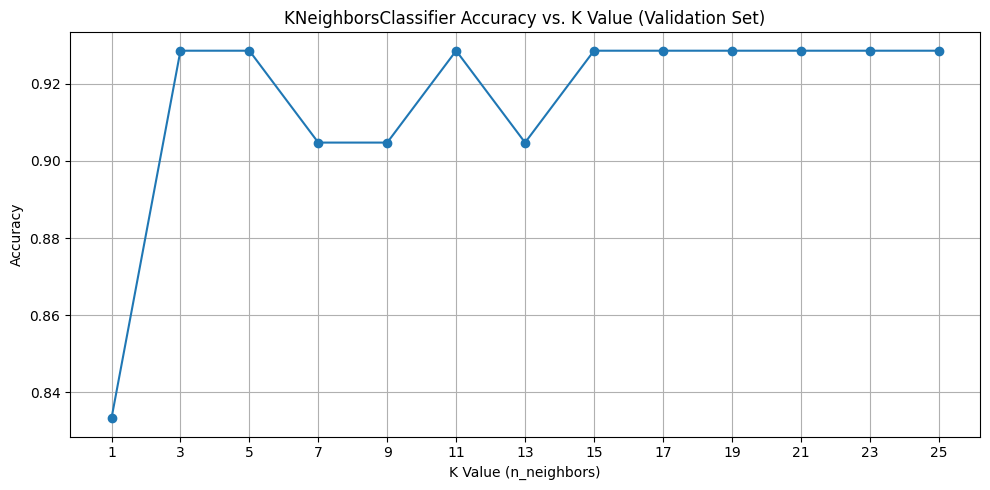


 KNeighborsClassifier training and evaluation completed for all specified k values.

 Optimal k on validation set: 3 with accuracy: 0.9286

 Evaluating KNeighborsClassifier with best k=3 on the Validation dataset:

  Validation Set Evaluation (K = 3)

  Accuracy on test set: 0.7727 



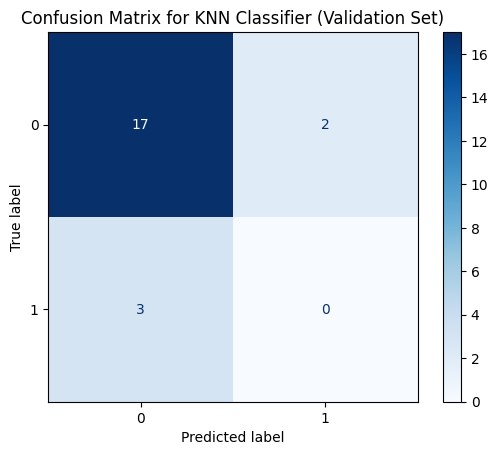

Classification Report for KNN Classifier (Validation Set): 

           Non-fatal  Fatal  accuracy  macro avg  weighted avg
precision   0.850000    0.0  0.772727   0.425000      0.734091
recall      0.894737    0.0  0.772727   0.447368      0.772727
f1-score    0.871795    0.0  0.772727   0.435897      0.752914
support    19.000000    3.0  0.772727  22.000000     22.000000


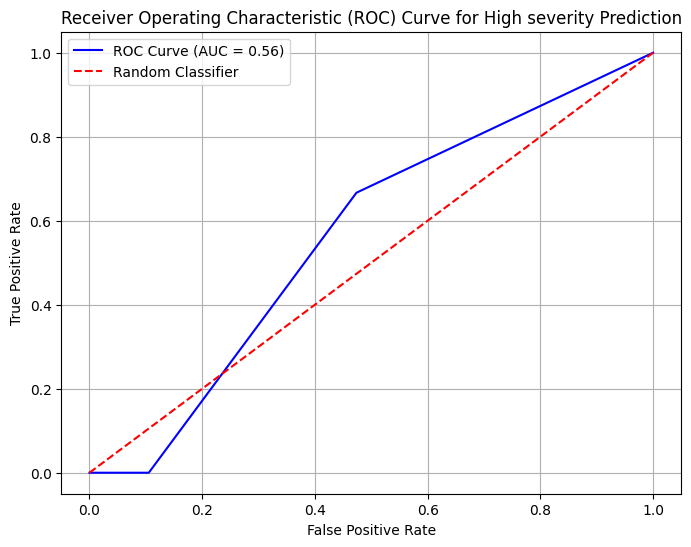


 ROC curve generated successfully. AUC Score: 0.5614


In [39]:
#Build feature set
X10 = df[['num_drivers_under_18','num_drivers_65_plus','street_type_primary', 'street_type_trunk', 'num_vehicle_motorbike', 'is_raining',
          'traffic_level_encoded','is_weekend','accident_time_category_night','accident_time_category_early_morning']]
#the slim version of the feture set is a biased version based on literature review to reduce feature set to avoid curse of dimensionality.

print("Overview of dataframe prepared for model training")
print(f"Shape of X (features): {X10.shape[0]} rows, {X10.shape[1]} columns represents all injected features")

# train/ test/validate dataset split
X10_train, X10_temp = train_test_split(X10, test_size=0.3, random_state=43)
X10_test, X10_val = train_test_split(X10_temp, test_size=0.33333333, random_state=43)

#normalizing data
# Apply StandardScaler to the training data (fit and transform)
X10_train = scaler.fit_transform(X10_train)
# Normalize X_test using the scaler fitted on X_train
X10_test = scaler.transform(X10_test)
# Apply StandardScaler to the validation data (transform only)
X10_val = scaler.transform(X10_val)

# define features
X_mix_train = np.hstack([X10_train])
X_mix_test = np.hstack([X10_test])
X_mix_val = np.hstack([X10_val])

# training model and returning results for multi hyperparamters
knn_results = knn_validation(X_mix_train, X_mix_test, y_train.iloc[:, 1],y_test.iloc[:, 1], k_values)
print(f"\n KNeighborsClassifier training and evaluation completed for all specified k values.")


# Find the best k based on validation accuracy
best_k = max(knn_results, key=knn_results.get)
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_test.fit(X_mix_train, y_train.iloc[:, 1])
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(X_mix_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_val.iloc[:, 1], y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_val.iloc[:,1], y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-fatal', 'Fatal']

# Generate and print the classification report
report = classification_report(y_val.iloc[:,1], y_pred_val, target_names=target_names, output_dict=True)

print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

#Get predicted probabilities for the positive class (Fatal=1)
y_pred_proba = knn_classifier_test.predict_proba(X_mix_val)[:, 1]

# Get true labels
y_true = y_val.iloc[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.12',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])
kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)

### 4.13 Training a CLASSIFIER using KNN to determine accident 'Fatality' based on feature set used by team

- use stratified testing
- 80/20 traintest split


Features: used Isaas'c  notebook


Accident Fatality (1: yes / 0: No)

Overview of dataframe prepared for model training
Shape of X (features): 211 rows, 33 columns represents all injected features
Shape of y (label): 211 rows, 1 column representing the label data
k=1, Fold 1: Accuracy = 0.9302
k=1, Fold 2: Accuracy = 0.8810
k=1, Fold 3: Accuracy = 0.8810
k=1, Fold 4: Accuracy = 0.9524
k=1, Fold 5: Accuracy = 0.7857
k=1 → Mean Accuracy: 0.8860 ± 0.0574

k=3, Fold 1: Accuracy = 0.8372
k=3, Fold 2: Accuracy = 0.7857
k=3, Fold 3: Accuracy = 0.8810
k=3, Fold 4: Accuracy = 0.9048
k=3, Fold 5: Accuracy = 0.7619
k=3 → Mean Accuracy: 0.8341 ± 0.0543

k=5, Fold 1: Accuracy = 0.8372
k=5, Fold 2: Accuracy = 0.8571
k=5, Fold 3: Accuracy = 0.8571
k=5, Fold 4: Accuracy = 0.8333
k=5, Fold 5: Accuracy = 0.7619
k=5 → Mean Accuracy: 0.8293 ± 0.0351

k=7, Fold 1: Accuracy = 0.8372
k=7, Fold 2: Accuracy = 0.8810
k=7, Fold 3: Accuracy = 0.8571
k=7, Fold 4: Accuracy = 0.8095
k=7, Fold 5: Accuracy = 0.8095
k=7 → Mean Accuracy: 0.8389 ± 0.0277

k=9, Fold 1: Accuracy = 0.8605
k=9

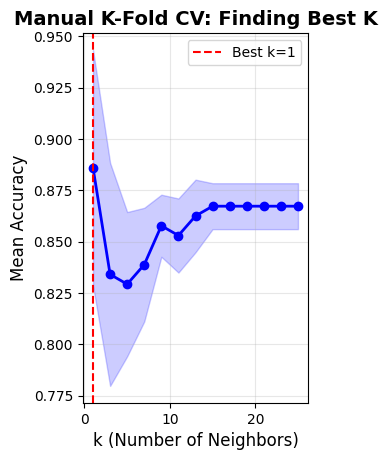

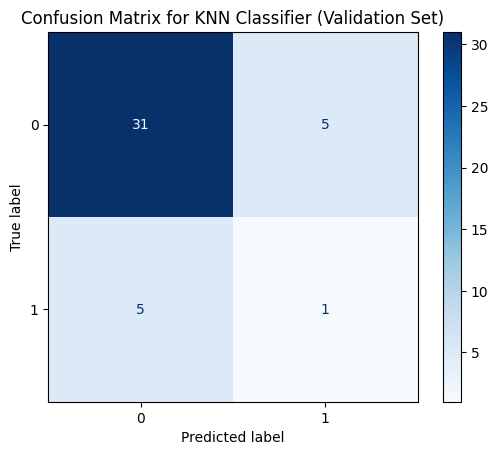

Classification Report for KNN Classifier (Validation Set): 

           Non-fatal     Fatal  accuracy  macro avg  weighted avg
precision   0.861111  0.166667  0.761905   0.513889      0.761905
recall      0.861111  0.166667  0.761905   0.513889      0.761905
f1-score    0.861111  0.166667  0.761905   0.513889      0.761905
support    36.000000  6.000000  0.761905  42.000000     42.000000


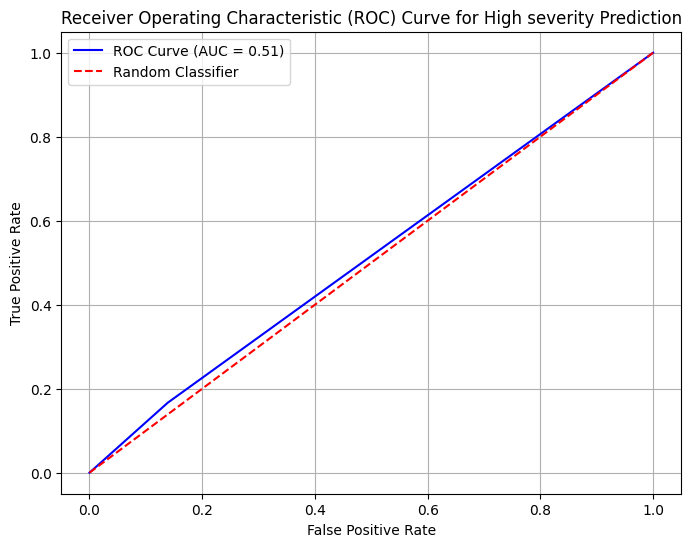


 ROC curve generated successfully. AUC Score: 0.5139


In [46]:
#Build feature set based on conclusion following team meeting - compare best outcoe from Log Regression, SVM and RF
Xteam = df[["num_drivers_under_18", "num_drivers_18_to_24", "num_drivers_25_to_49", "num_drivers_65_plus", #, "num_drivers_50_to_64"
        "num_drivers_male", "num_drivers_female", "num_vehicle_unknown", #"num_drivers_age_unknown", "num_drivers_gender_unknown"
        "num_vehicle_pedestrian", "num_vehicle_bicycle", "num_vehicle_motorbike", "num_vehicle_car", "num_vehicle_van", #"num_vehicle_bus",
        "is_weekend", "is_school_holiday_mt", "temperature_mean", "is_raining", 'accident_time_category_early_morning',
        'accident_time_category_morning', 'accident_time_category_afternoon', 'accident_time_category_evening',
        'accident_time_category_late_evening', 'accident_time_category_night', 'street_type_other','street_type_primary',
        'street_type_residential','street_type_secondary','street_type_tertiary','street_type_trunk', 'region_Central',
        'region_Gozo','region_Northern','region_South Eastern','region_Southern Harbour']]
#the four removed features are based to conclusion form feature importance determined from RF analysis (Isaac's notebook).

#Redefine target label ot focus only on 'fatality
yteam = df[['fatality']]

print("Overview of dataframe prepared for model training")
print(f"Shape of X (features): {Xteam.shape[0]} rows, {Xteam.shape[1]} columns represents all injected features")
print(f"Shape of y (label): {yteam.shape[0]} rows, {yteam.shape[1]} column representing the label data")

#***************change stratification method and find best 'k'*****************************#

# Storage for results
k_scores = []




# Setup stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)

# Loop through each k value
for k in k_values:
    fold_scores = []

    # Perform cross-validation for this k
    for fold, (train_idx, val_idx) in enumerate(skf.split(Xteam, yteam), 1):
        # Split data
        X_fold_train = Xteam.iloc[train_idx] if hasattr(Xteam, 'iloc') else Xteam[train_idx]
        X_fold_val = Xteam.iloc[val_idx] if hasattr(Xteam, 'iloc') else Xteam[val_idx]
        y_fold_train = yteam.iloc[train_idx] if hasattr(yteam, 'iloc') else yteam[train_idx]
        y_fold_val = yteam.iloc[val_idx] if hasattr(yteam, 'iloc') else yteam[val_idx]

        # Fit scaler on training data ONLY
        scaler = StandardScaler()
        X_fold_train_scaled = scaler.fit_transform(X_fold_train)
        # Transform validation data using training statistics
        X_fold_val_scaled = scaler.transform(X_fold_val)

        # Train KNN with current k
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_fold_train_scaled, y_fold_train)

        # Predict and evaluate
        y_pred = knn.predict(X_fold_val_scaled)
        accuracy = accuracy_score(y_fold_val, y_pred)
        fold_scores.append(accuracy)

        print(f"k={k}, Fold {fold}: Accuracy = {accuracy:.4f}")

    # Average score across all folds for this k
    avg_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    k_scores.append({
        'k': k,
        'mean_accuracy': avg_score,
        'std_accuracy': std_score
    })
    print(f"k={k} → Mean Accuracy: {avg_score:.4f} ± {std_score:.4f}\n")

# Convert to DataFrame for easy analysis
results_df = pd.DataFrame(k_scores)

# Find best k
best_k = results_df.loc[results_df['mean_accuracy'].idxmax(), 'k']
best_score = results_df.loc[results_df['mean_accuracy'].idxmax(), 'mean_accuracy']

print(f"\n{'='*50}")
print(f"BEST K: {int(best_k)} with accuracy: {best_score:.4f}")
print(f"{'='*50}\n")

# Plotting results
plt.subplot(1, 2, 1)
plt.plot(results_df['k'], results_df['mean_accuracy'], 'b-o', linewidth=2, markersize=6)
plt.fill_between(results_df['k'],
                 results_df['mean_accuracy'] - results_df['std_accuracy'],
                 results_df['mean_accuracy'] + results_df['std_accuracy'],
                 alpha=0.2, color='blue')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k={int(best_k)}')
plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.title('Manual K-Fold CV: Finding Best K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()



# re-train using optimal hyper parameter
knn_classifier_test = KNeighborsClassifier(n_neighbors=best_k) #, metric='manhattan')
knn_classifier_test.fit(X_fold_train,y_fold_train)
print(f"\n Evaluating KNeighborsClassifier with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_classifier_test.predict(X_fold_val)

# Calculate accuracy on the validation set
test_accuracy = accuracy_score(y_fold_val, y_pred_val)
print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  Accuracy on test set: {test_accuracy:.4f} \n")

# Generate the confusion matrix
cm = confusion_matrix(y_fold_val, y_pred_val)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier_test.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier (Validation Set)')
plt.show()

# Define target names for clarity in the report
target_names = ['Non-fatal', 'Fatal']

# Generate and print the classification report
report = classification_report(y_fold_val, y_pred_val, target_names=target_names, output_dict=True)

print("Classification Report for KNN Classifier (Validation Set): \n")
print(pd.DataFrame(report))

#Get predicted probabilities for the positive class (Fatal=1)
y_pred_proba = knn_classifier_test.predict_proba(X_fold_val)[:, 1]


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_fold_val, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_fold_val, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for High severity Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n ROC curve generated successfully. AUC Score: {auc_score:.4f}")

# store main conclusions in KPI matrix
test_data = pd.DataFrame([{
    'Test Name': 'Test 4.13',
    'k Value': best_k,
    'Accuracy': test_accuracy,
    'Class 0 Precision': report[target_names[0]]['precision'],
    'Class 1 Precision': report[target_names[1]]['precision'],
    'Class 0 Recall': report[target_names[0]]['recall'],
    'Class 1 Recall': report[target_names[1]]['recall'],
    'Class 0 F1 Score': report[target_names[0]]['f1-score'],
    'Class 1 F1 Score': report[target_names[1]]['f1-score'],
    'AUG': auc_score

}])
kpi_table = pd.concat([kpi_table, test_data], ignore_index=True)

### 4.14 Training a REGRESSION model using KNN to determine number of injured people based on reduced features model

**For Exploratory purposes only!**

Features:  selective features
            - Xslim dataset


Label:     Number of injured people (integer) --- > `y[:,2]`


 Training and evaluating KNN Regressor for different k values:


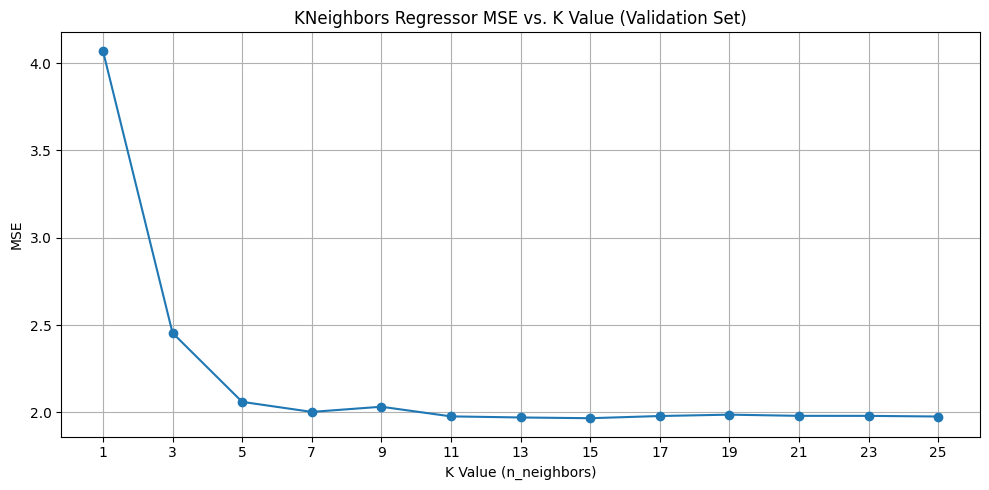


 KNeighbors Regression training and evaluation completed for all specified k values.

 Optimal k on validation set: 15 with accuracy: 1.9663

 Evaluating KNeighbors Regressor with best k=15 on the Validation dataset:

  Validation Set Evaluation (K = 15)

  MSE on validation set: 0.3160 


  R2 score on validation set: 0.0442 


✓ KNN Regression model for 'total_injured' built and evaluated successfully.


In [41]:
#define features
X_mix_train = np.hstack([Xdriver_train,Xvehicle_train])
X_mix_test = np.hstack([Xdriver_test, Xvehicle_test])
X_mix_val = np.hstack([Xdriver_val, Xvehicle_val])


# training model and returning results for multiple hyperparamters
knn_results = Reg_knn_validation(X_mix_train, X_mix_test, y_train.iloc[:, 2],y_test.iloc[:, 2], k_values)
print(f"\n KNeighbors Regression training and evaluation completed for all specified k values.")


# Find the best k based on validation accuracy
best_k = min(knn_results, key=knn_results.get) #changed to 'min'
best_accuracy = knn_results[best_k]
print(f"\n Optimal k on validation set: {best_k} with accuracy: {best_accuracy:.4f}")

# re-train using optimal hyper parameter
knn_regressor_test = KNeighborsRegressor(n_neighbors=best_k, metric='euclidean')
knn_regressor_test.fit(X_mix_train, y_train.iloc[:, 2]) # Changed target to column 2 for 'total_injured'
print(f"\n Evaluating KNeighbors Regressor with best k={best_k} on the Validation dataset:")

# Make predictions on the validation set
y_pred_val = knn_regressor_test.predict(X_mix_val)

# Evaluate the model on the test set
mse_val = mean_squared_error(y_val.iloc[:, 2], y_pred_val)
r2_val = r2_score(y_val.iloc[:, 2], y_pred_val)


print(f"\n  Validation Set Evaluation (K = {best_k})")
print(f"\n  MSE on validation set: {mse_val:.4f} \n")
print(f"\n  R2 score on validation set: {r2_val:.4f} \n")

print("\n✓ KNN Regression model for 'total_injured' built and evaluated successfully.")

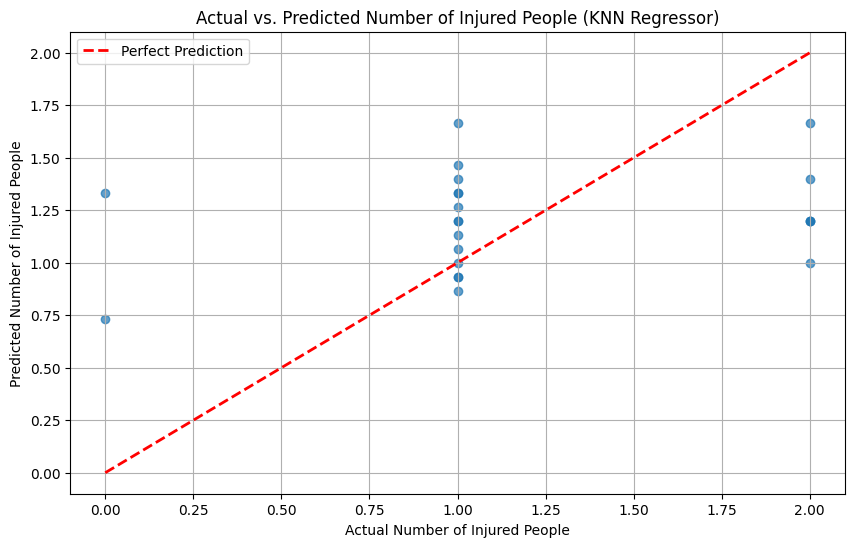

✓ Scatter plot of actual vs. predicted values generated successfully.


In [42]:
import matplotlib.pyplot as plt

# Assuming y_val_reg contains the true values for 'total_injured' from the validation set
# Assuming y_pred_val_reg contains the predicted values from the KNN regressor

plt.figure(figsize=(10, 6))
plt.scatter(y_val.iloc[:, 2], y_pred_val, alpha=0.7)
plt.plot([y_val.iloc[:, 2].min(), y_val.iloc[:, 2].max()], [y_val.iloc[:, 2].min(), y_val.iloc[:, 2].max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Number of Injured People')
plt.ylabel('Predicted Number of Injured People')
plt.title('Actual vs. Predicted Number of Injured People (KNN Regressor)')
plt.legend()
plt.grid(True)
plt.show()

print("✓ Scatter plot of actual vs. predicted values generated successfully.")

## 5. Evaluation

From the various scenarios set to train a KNN classifier we did not achieve a satisfactory performance as f1 score was in most cases >85% only to predict one classification.
From the literature review we attribute this challenge for KNN to predict either severity or fatality to two main issues:

- data scarcity and imbalance. Our data set is very limited and also highliy imbalanced
- There is no clear segregation between data and thus a distance base model will struggle to distinguish between the two classes


In the different scenraios carried out in section 4 we have reduces the feture set from 37 to 10 in effort to reduce curse of dimensionlity.

The next section we perform PCA to visualize that the above mentioned point about data sparcity and overlap between classes

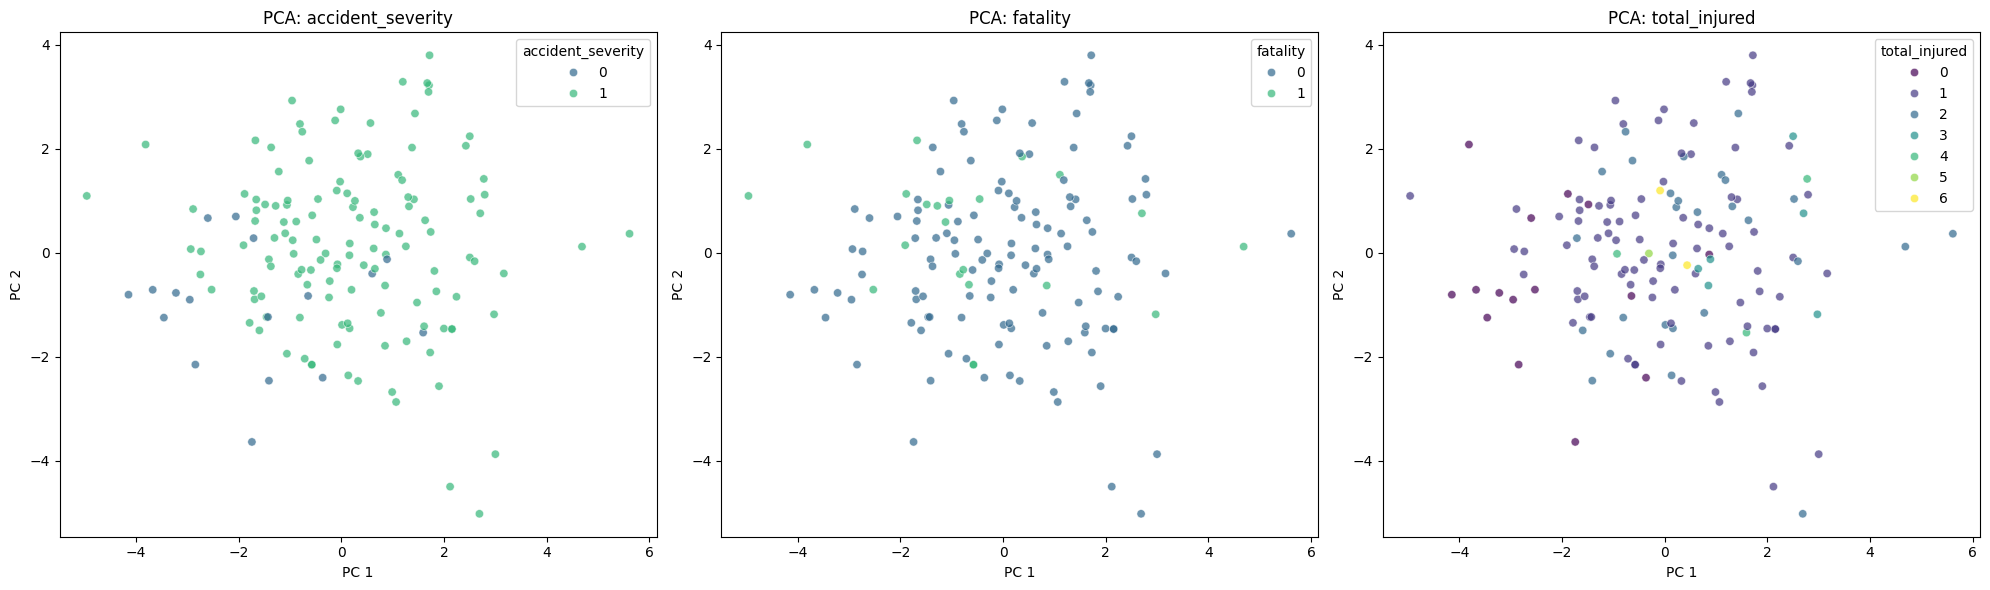

In [43]:
# Select the target variables for PCA from the training set
y_pca_data = y_train[['accident_severity', 'fatality', 'total_injured']]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, col in enumerate(y_pca_data.columns):
    sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=y_pca_data[col],
        palette='viridis',
        alpha=0.7,
        ax=axes[i]  # Direct the plot to the specific subplot
    )
    axes[i].set_title(f'PCA: {col}')
    axes[i].set_xlabel('PC 1')
    axes[i].set_ylabel('PC 2')
    axes[i].legend(title=col, loc='upper right')

plt.tight_layout()
plt.show()

##6. Results

In [47]:
print(" Tabulated result for each Experiment")
kpi_table

 Tabulated result for each Experiment


,Test Name,k Value,Accuracy,Class 0 Precision,Class 1 Precision,Class 0 Recall,Class 1 Recall,Class 0 F1 Score,Class 1 F1 Score,AUG
0,Test 4.1,3.0,0.863636,0.333333,0.947368,0.500000,0.900000,0.400000,0.923077,0.862500
1,Test 4.2,1.0,0.818182,0.894737,0.333333,0.894737,0.333333,0.894737,0.333333,0.614035
2,Test 4.3,5.0,0.909091,0.000000,0.909091,0.000000,1.000000,0.000000,0.952381,0.387500
3,Test 4.4,7.0,0.863636,0.863636,0.000000,1.000000,0.000000,0.926829,0.000000,0.526316
4,Test 4.5,3.0,0.863636,0.000000,0.904762,0.000000,0.950000,0.000000,0.926829,0.687500
5,Test 4.6,15.0,0.863636,0.863636,0.000000,1.000000,0.000000,0.926829,0.000000,0.385965
6,Test 4.7,3.0,0.909091,0.000000,0.909091,0.000000,1.000000,0.000000,0.952381,0.825000
7,Test 4.8,17.0,0.863636,0.863636,0.000000,1.000000,0.000000,0.926829,0.000000,0.552632
8,Test 4.9,5.0,0.909091,0.000000,0.909091,0.000000,1.000000,0.000000,0.952381,0.687500
9,Test 4.10,5.0,0.863636,0.863636,0.000000,1.000000,0.000000,0.926829,0.000000,0.535088


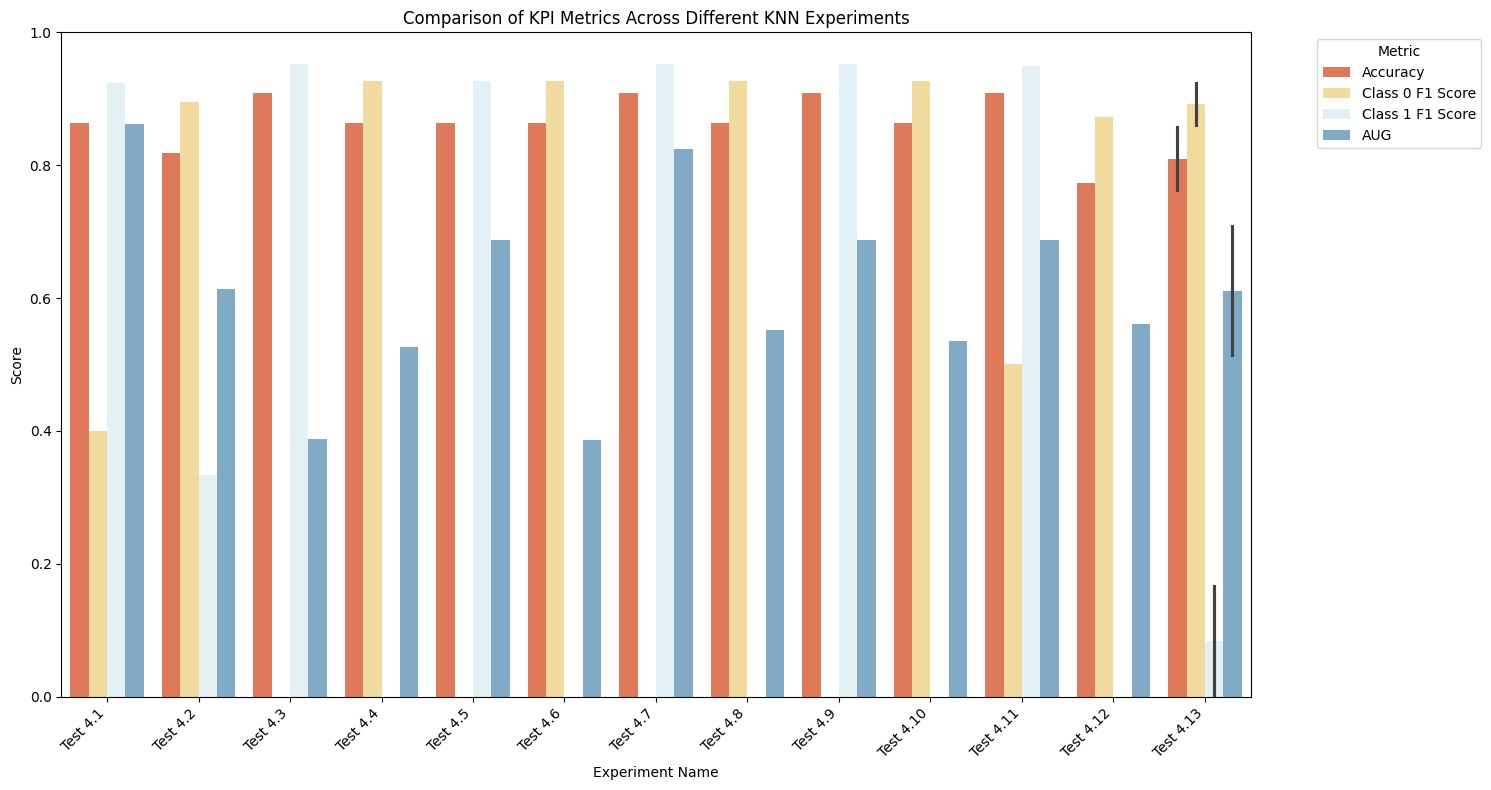

In [48]:
#split KPI group
kpi_melted = kpi_table.melt(id_vars=['Test Name', 'k Value'],
                          value_vars=['Accuracy', 'Class 0 F1 Score', 'Class 1 F1 Score', 'AUG'],
                          var_name='Metric', value_name='Score')

plt.figure(figsize=(15, 8))
sns.barplot(x='Test Name', y='Score', hue='Metric', data=kpi_melted, palette='RdYlBu')
plt.title('Comparison of KPI Metrics Across Different KNN Experiments')
plt.xlabel('Experiment Name')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 7. Interpretation

## 8. Limitations and Ethical considerations